In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from os.path import join, abspath
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
import lightgbm as lgb

project_dir = abspath("../")

if project_dir not in sys.path:
    sys.path.append(project_dir)
    print("Added {} to path".format(project_dir))

from preprocessing.feature_analysis import near_zero_variance_analysis
from analysis.feature_importance import feat_importance_mdi, feat_importance_mda

Added /Users/igorpesic/projects/ml_utils to path


In [2]:
def confusion_matrix_df(y_true, y_pred):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = [cm[i,i] / cm[:, i].sum() for i in range(cm.shape[0])]

    cm = np.vstack([cm, precision])
    cm = pd.DataFrame(cm, index=[f"true_{i+1}" for i in np.arange(n_classes)]+["precision"],
                     columns=[f"pred_{i+1}" for i in np.arange(n_classes)])
    cm["recall"] = [cm.iloc[i,i] / cm.iloc[i, :].sum() for i in range(n_classes)] + [accuracy]
    
    return cm

# Load data

In [3]:
file_train = "data/train.csv"
file_test = "data/test.csv"
df_train = pd.read_csv(file_train, index_col=0)
df_test = pd.read_csv(file_test, index_col=0)

feat_cols = [c for c in df_train.columns if "feat" in c]
df_train["target"] = df_train["target"].str.get(-1).astype(int)

n, d = df_train.shape
d = d - 1 # remove target
print(f"Data shape: {df_train.shape}")

# shuffle
df_train = df_train.sample(frac=1, random_state=442)   
df_train.head()

Data shape: (61878, 94)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
id,,,,,,,,,,,,,,,,,,,,,
50982,1,2,0,0,0,0,1,1,0,1,...,1,2,0,0,0,16,1,0,0,8
8052,0,0,0,0,0,0,0,1,0,0,...,0,0,1,5,1,0,0,0,0,2
29980,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,5
18411,2,0,0,0,0,0,0,0,0,0,...,1,1,0,9,0,0,0,0,0,3
37440,0,0,6,7,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,6


# Feature analysis

In [4]:
d = d + 1
df_train[f"feat_{d}"] = (df_train[feat_cols] != 0).sum(axis=1)
d = d + 1
df_train[f"feat_{d}"] = df_train[feat_cols].sum(axis=1)

<IPython.core.display.Javascript object>


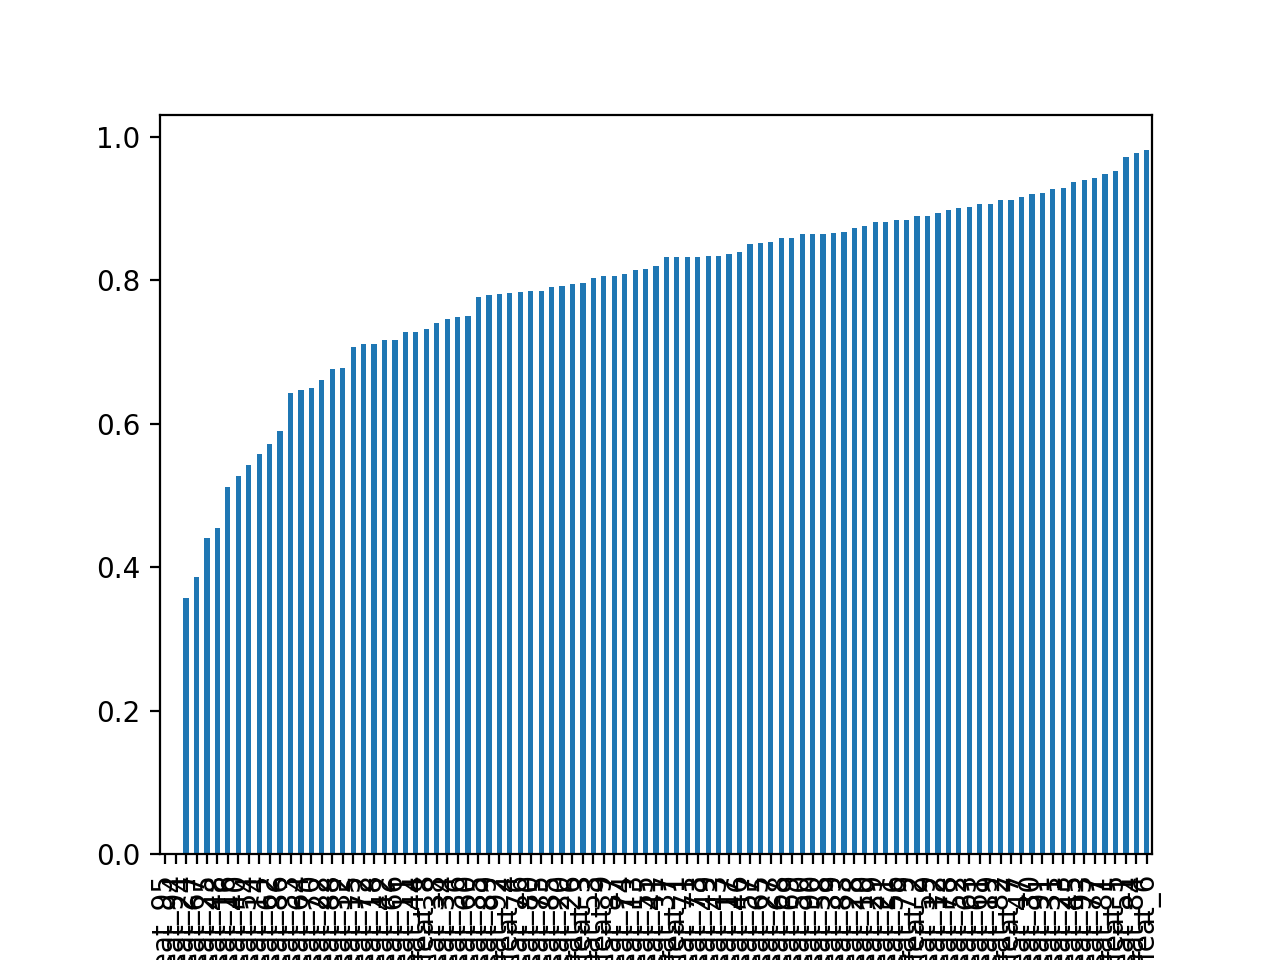

In [12]:
feature_sparsity = 1.0 - df_train.drop(columns=["target"]).astype(bool).sum(axis=0) / df_train.shape[0]
fig, ax = plt.subplots()
feature_sparsity.sort_values().plot.bar(ax=ax)

In [6]:
for i in range(d):
    for j in range(i, d):
        all_zeros = (df_train[f"feat_{i+1}"] * df_train[f"feat_{j+1}"] == 0).all()
        if all_zeros:
            print(f"feat_{i+1} and feat_{j+1} have no common non-zero data")

In [7]:
zv_analysis = near_zero_variance_analysis(df_train.iloc[:,:d])
zv_analysis["sparsity"] = feature_sparsity
zv_analysis = zv_analysis.loc[zv_analysis["zeroVar"] | zv_analysis["nearZeroVar"]]
nzv_features = list(zv_analysis.index)
zv_analysis


# turned out useles because of high sparsity...

,freqRatio,percentUnique,zeroVar,nearZeroVar,sparsity
feat_5,24.992363,0.000242,False,True,0.951986
feat_6,68.754250,0.000145,False,True,0.981124
feat_23,22.484350,0.000388,False,True,0.928763
feat_45,22.078007,0.001228,False,True,0.937668
feat_47,20.102127,0.000630,False,True,0.916125
feat_51,55.293198,0.000356,False,True,0.972220
feat_61,22.394169,0.000372,False,True,0.906219
feat_77,25.593859,0.000388,False,True,0.943049
feat_81,25.409090,0.000307,False,True,0.948560
feat_84,65.855118,0.000679,False,True,0.977003


<IPython.core.display.Javascript object>


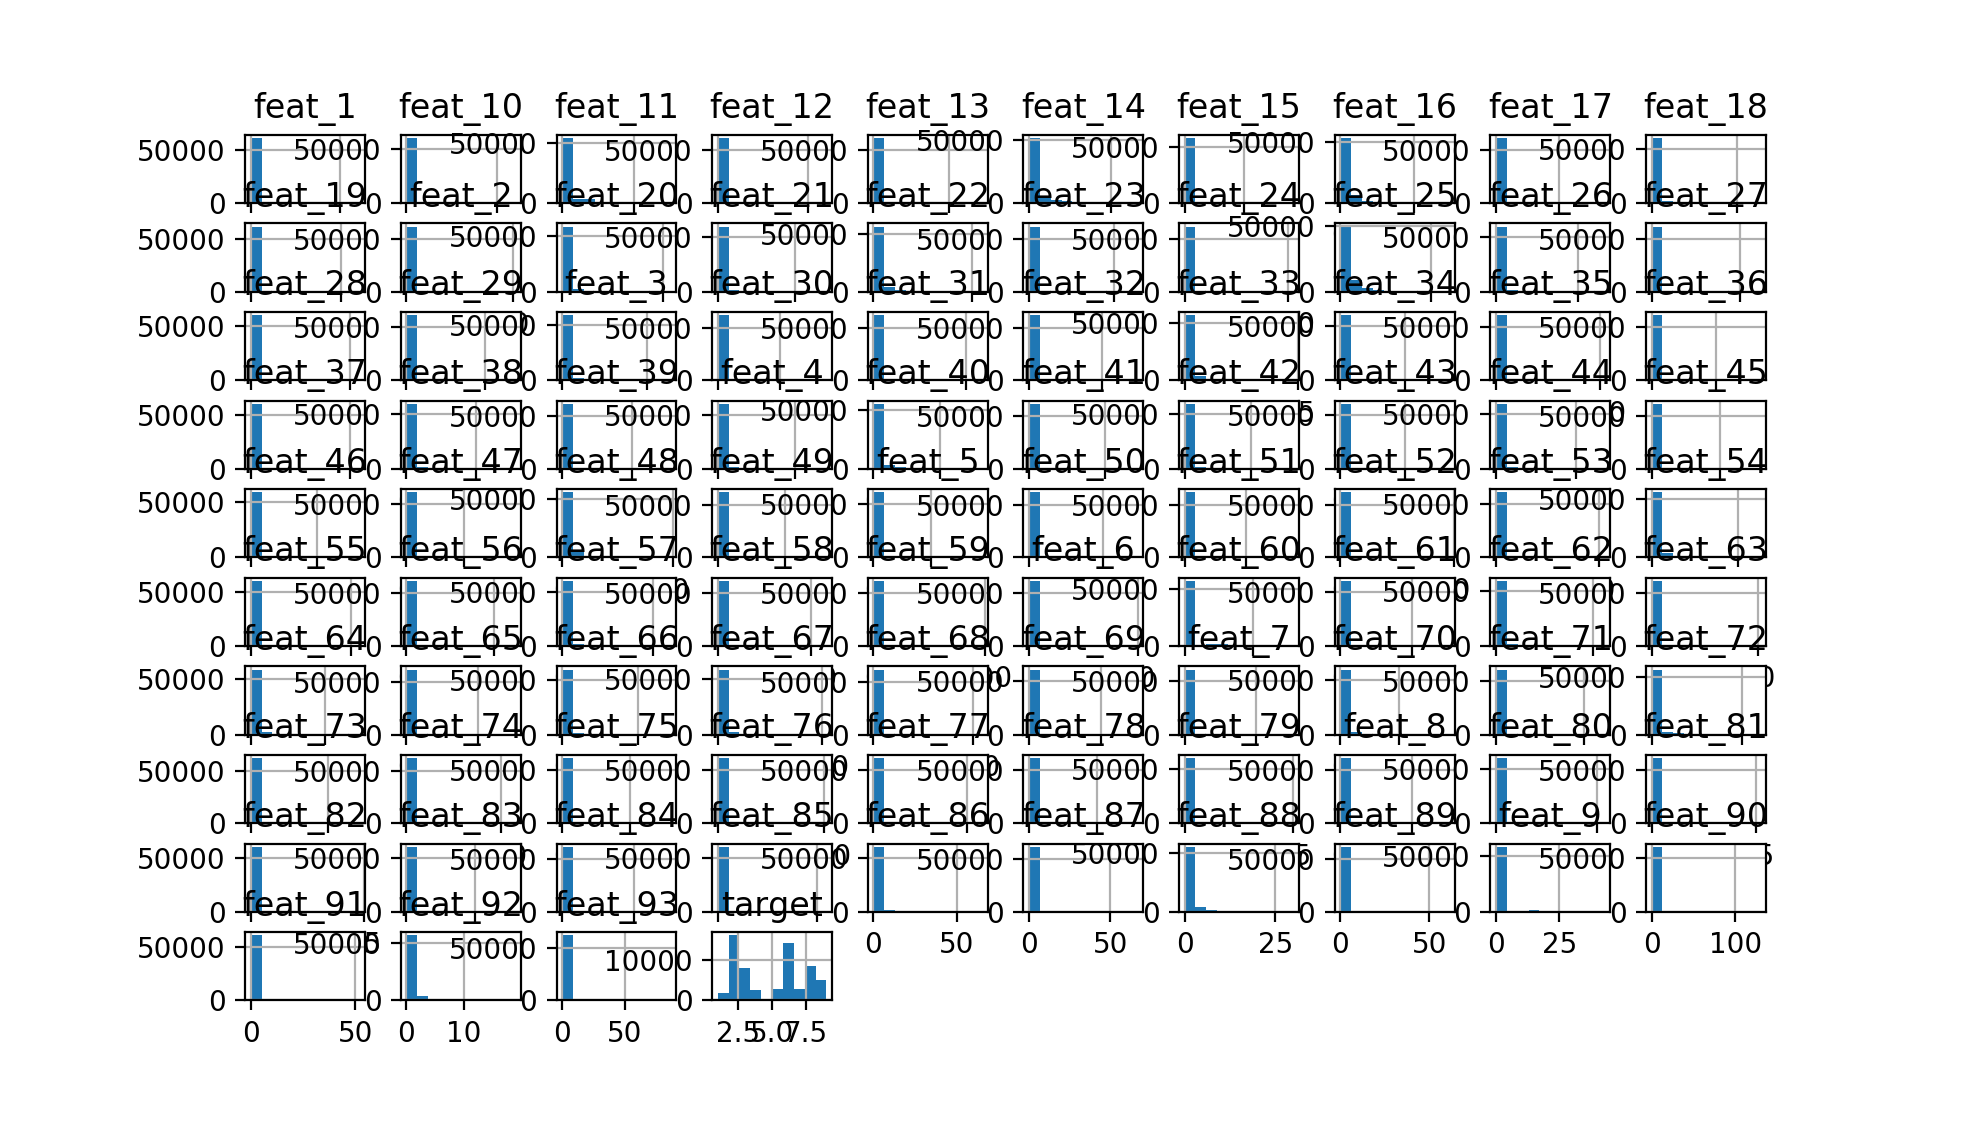

<ipython-input-13-c9731238bc2b>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  ax = df_train.hist(ax=ax)


In [13]:
fig, ax = plt.subplots()
ax = df_train.hist(ax=ax)

<IPython.core.display.Javascript object>


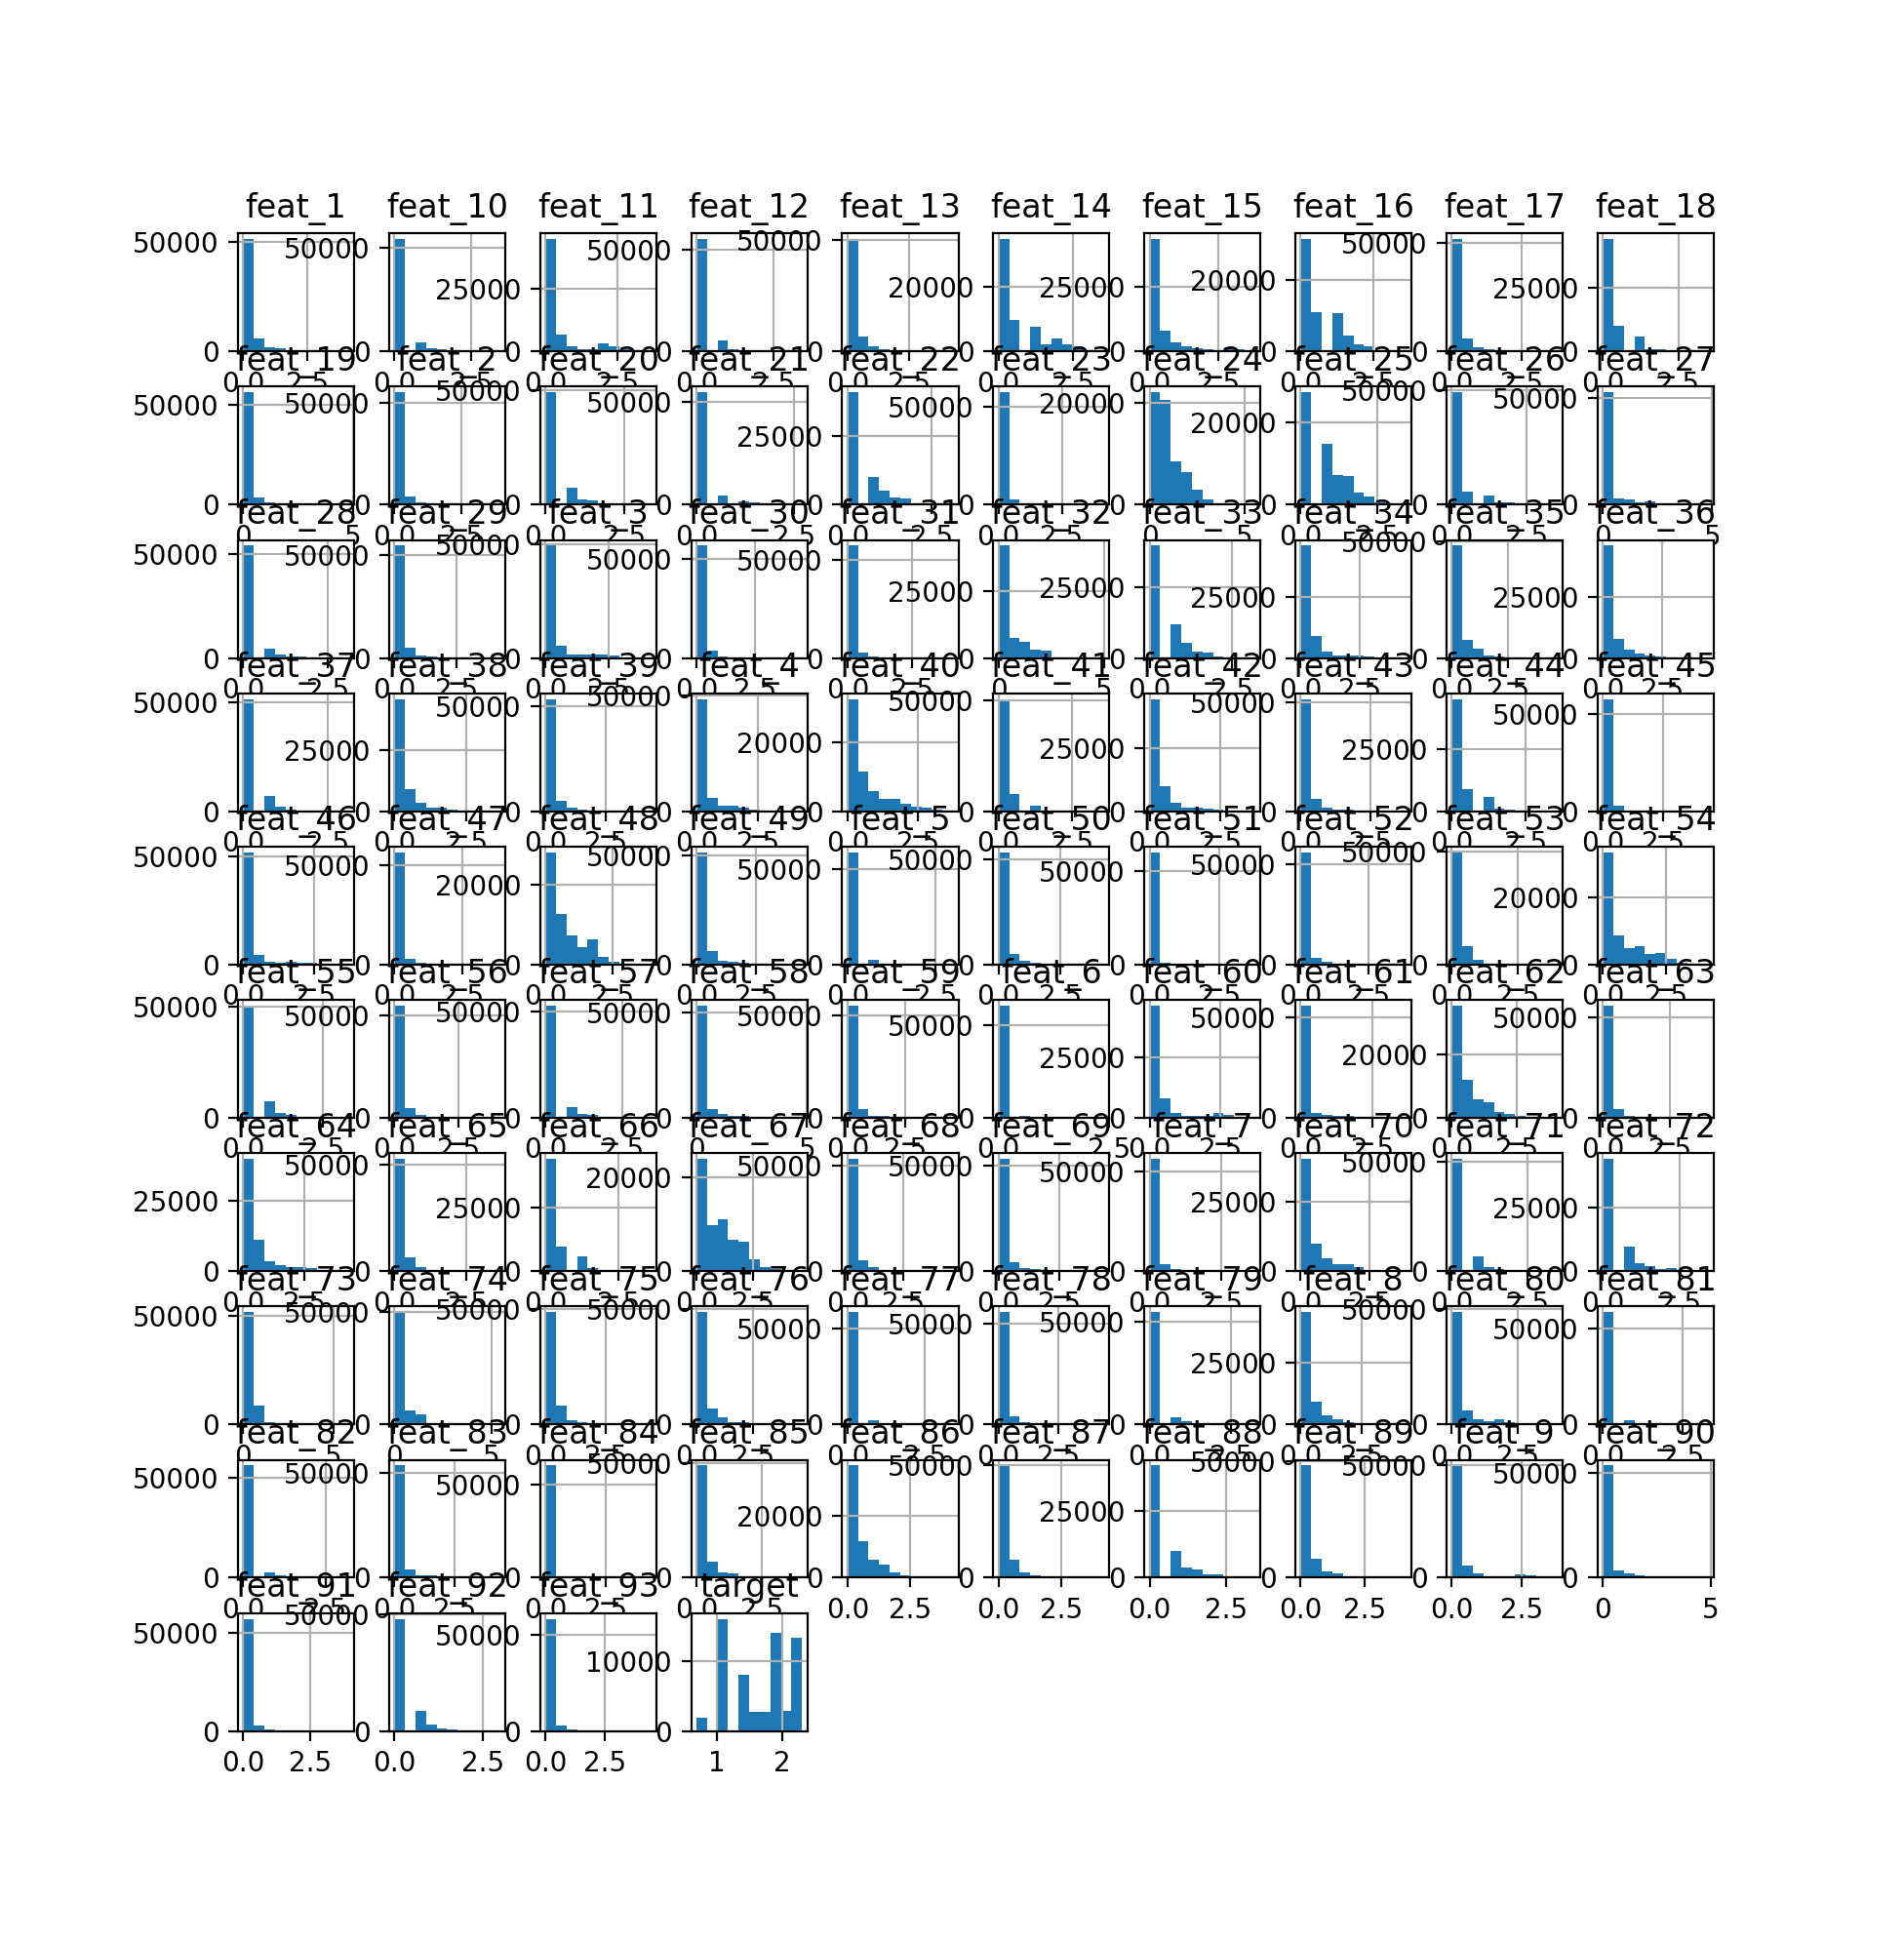

<ipython-input-102-2ef7b50886ba>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  ax = df_log.hist(ax=ax)


In [102]:
fig, ax = plt.subplots()
df_log = df_train.copy()
df_log.iloc[:] = np.log(df_log.values + 1)

ax = df_log.hist(ax=ax)

In [5]:
print("Number of samples per class:")
class_sizes = df_train["target"].value_counts()
n_classes = len(class_sizes)
class_sizes

Number of samples per class:


2    16122
6    14135
8     8464
3     8004
9     4955
7     2839
5     2739
4     2691
1     1929
Name: target, dtype: int64

## Feature Correlation

<IPython.core.display.Javascript object>


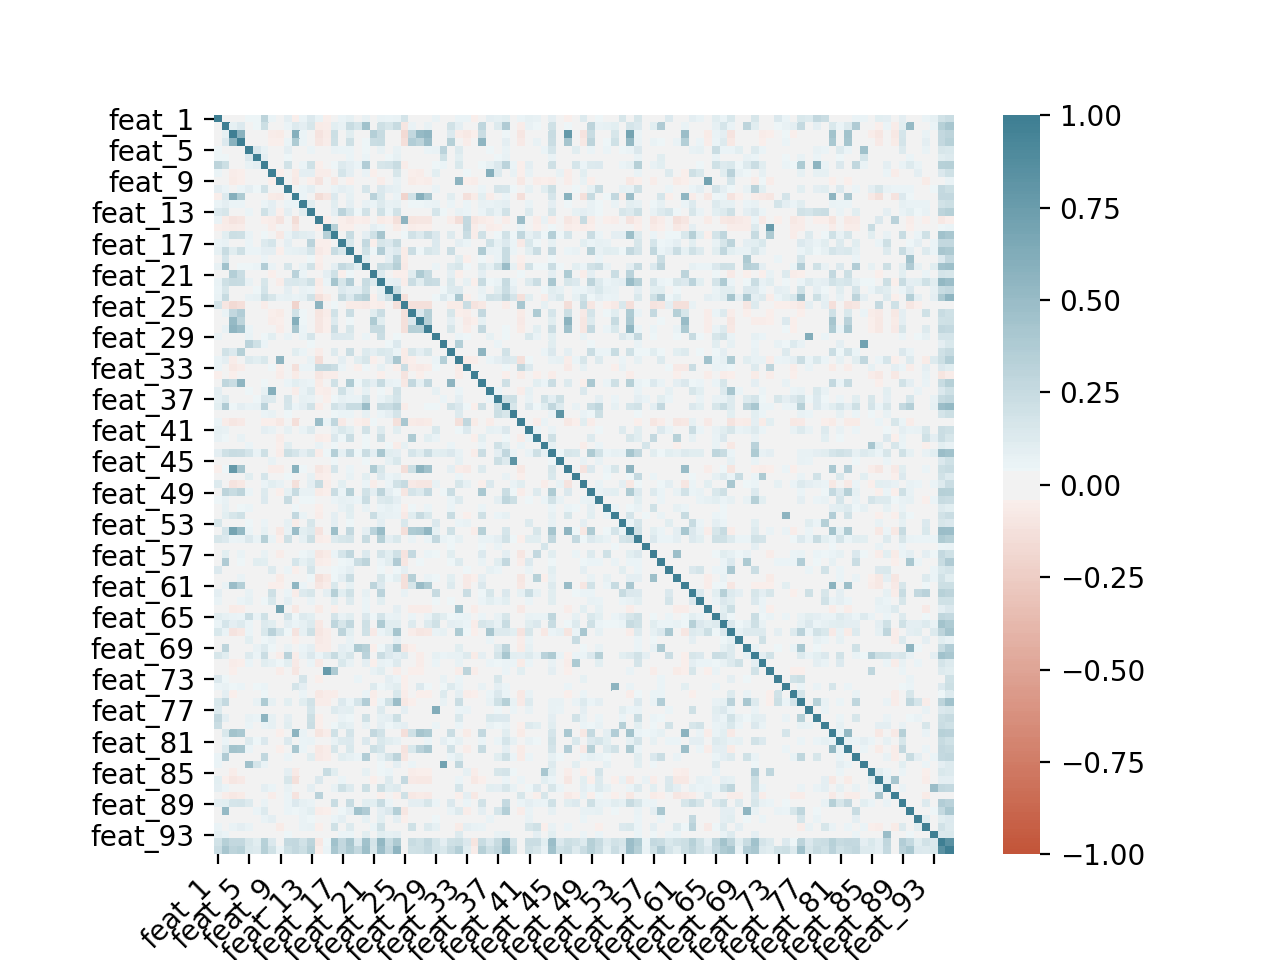

In [20]:
corr = df_train.drop(columns=["target"]).corr()

fig, ax = plt.subplots()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [22]:
def show_correlated_feat(corr, top=30, feature_sparsity=None):
    corr = np.array(corr)
    corr_clean = np.abs(corr.copy())
    for i in range(corr.shape[0]):
        corr_clean[i, i:] = 0.0

    top_20_argmax = corr_clean.flatten().argsort()[-top:][::-1]

    argmax_2d = np.unravel_index(top_20_argmax, corr_clean.shape)
    for x,y in zip(*argmax_2d):
        print(f"Feats {x+1} and {y+1}: corr={corr[x,y]:.2f}")
        if feature_sparsity is not None:
            print(f"    Sparsity: {feature_sparsity[f'feat_{x+1}']:.2f}  {feature_sparsity[f'feat_{y+1}']:.2f}")
        
show_correlated_feat(corr, feature_sparsity=feature_sparsity)

Feats 95 and 94: corr=0.84
    Sparsity: 0.00  0.00
Feats 45 and 39: corr=0.82
    Sparsity: 0.94  0.87
Feats 46 and 3: corr=0.78
    Sparsity: 0.84  0.80
Feats 72 and 15: corr=0.76
    Sparsity: 0.71  0.71
Feats 84 and 30: corr=0.72
    Sparsity: 0.98  0.92
Feats 64 and 9: corr=0.70
    Sparsity: 0.65  0.81
Feats 54 and 3: corr=0.69
    Sparsity: 0.54  0.80
Feats 77 and 29: corr=0.61
    Sparsity: 0.94  0.88
Feats 36 and 8: corr=0.61
    Sparsity: 0.75  0.73
Feats 27 and 11: corr=0.60
    Sparsity: 0.85  0.73
Feats 11 and 3: corr=0.60
    Sparsity: 0.73  0.80
Feats 4 and 3: corr=0.58
    Sparsity: 0.78  0.80
Feats 46 and 11: corr=0.58
    Sparsity: 0.84  0.73
Feats 80 and 61: corr=0.58
    Sparsity: 0.78  0.91
Feats 46 and 27: corr=0.57
    Sparsity: 0.84  0.85
Feats 54 and 46: corr=0.57
    Sparsity: 0.54  0.84
Feats 32 and 9: corr=0.57
    Sparsity: 0.68  0.81
Feats 78 and 7: corr=0.57
    Sparsity: 0.90  0.91
Feats 80 and 11: corr=0.56
    Sparsity: 0.78  0.73
Feats 25 and 14: corr

Since there are too many correlated features, we shall run PCA to remove the correlation

In [23]:
subsample_size = 40000
pca = PCA(n_components=d)
log_data = np.log(df_train.drop(columns=["target"]) + 1)
log_data = log_data.iloc[:subsample_size]  # subsample for speed
scaler = StandardScaler()
scaled = scaler.fit_transform(log_data)
X_pca = pca.fit_transform(scaled)
X_pca = pd.DataFrame(data=X_pca, index=log_data.index, columns=log_data.columns)

y_pca = df_train["target"].iloc[:subsample_size]
X_pca.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
id,,,,,,,,,,,,,,,,,,,,,
27872,-3.655817,-0.850742,-0.123860,-0.174278,-1.153356,-0.075869,0.240623,1.303701,0.157804,1.470244,...,-0.232626,0.219604,-0.195759,0.371729,-0.145086,0.029655,0.419961,-0.160869,0.420704,-0.266154
46137,-0.625253,-0.139219,-1.114160,1.122822,-1.407261,-2.638952,2.328644,1.545370,-0.307427,-1.033376,...,-0.039963,0.543529,-0.551317,-0.338037,-0.192151,0.151721,0.361095,0.146480,-0.632614,-0.205040
55404,-0.083087,0.749931,0.824016,1.727250,-0.118853,-1.093003,3.277638,-0.816026,0.828528,0.560316,...,0.314854,-0.581524,0.359398,0.584516,-0.004504,1.471710,0.210760,0.396280,-0.343715,-0.162288
8516,-3.586269,-0.094166,-0.010542,-0.127197,-0.345971,1.177129,-0.004896,0.575274,-0.184636,-0.557428,...,-0.652371,1.156562,0.218623,-0.092711,-0.363153,-0.160313,0.363608,-0.229326,0.300412,0.184376
22585,-3.065451,-0.904797,-0.327780,0.200711,-1.078166,0.282571,0.100948,0.233165,0.122731,-0.058324,...,-0.580008,0.768002,0.383060,-0.080194,-0.049281,-0.127831,-0.967921,0.302219,0.651201,-0.195428


## Feature Importance

In [40]:

from sklearn.metrics import confusion_matrix, accuracy_score

rf = RandomForestClassifier(n_estimators=1500, n_jobs=-1)
X = df_train.drop(columns=["target"])
y = df_train["target"]

X_train = X.iloc[:40000]
y_train = y.iloc[:40000]

X_test = X.iloc[40000:]
y_test = y.iloc[40000:]

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


confusion_matrix_df(y_test, y_pred)

,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,recall
true_1,236.000000,32.000000,1.000000,1.000000,1.000000,55.000000,20.000000,157.000000,140.000000,0.367030
true_2,0.000000,5094.000000,501.000000,30.000000,9.000000,9.000000,29.000000,18.000000,8.000000,0.893998
true_3,0.000000,1431.000000,1301.000000,26.000000,1.000000,3.000000,37.000000,17.000000,6.000000,0.461021
true_4,0.000000,429.000000,134.000000,392.000000,8.000000,31.000000,6.000000,0.000000,0.000000,0.392000
true_5,1.000000,22.000000,0.000000,0.000000,952.000000,2.000000,0.000000,1.000000,0.000000,0.973415
true_6,5.000000,50.000000,3.000000,2.000000,3.000000,4789.000000,52.000000,91.000000,52.000000,0.948881
true_7,6.000000,133.000000,61.000000,15.000000,6.000000,81.000000,593.000000,99.000000,8.000000,0.591816
true_8,16.000000,29.000000,6.000000,0.000000,1.000000,84.000000,11.000000,2747.000000,36.000000,0.937543
true_9,15.000000,49.000000,3.000000,0.000000,0.000000,58.000000,4.000000,67.000000,1562.000000,0.888510
precision,0.845878,0.700784,0.647264,0.841202,0.970438,0.936815,0.788564,0.859243,0.862031,0.807478


<IPython.core.display.Javascript object>


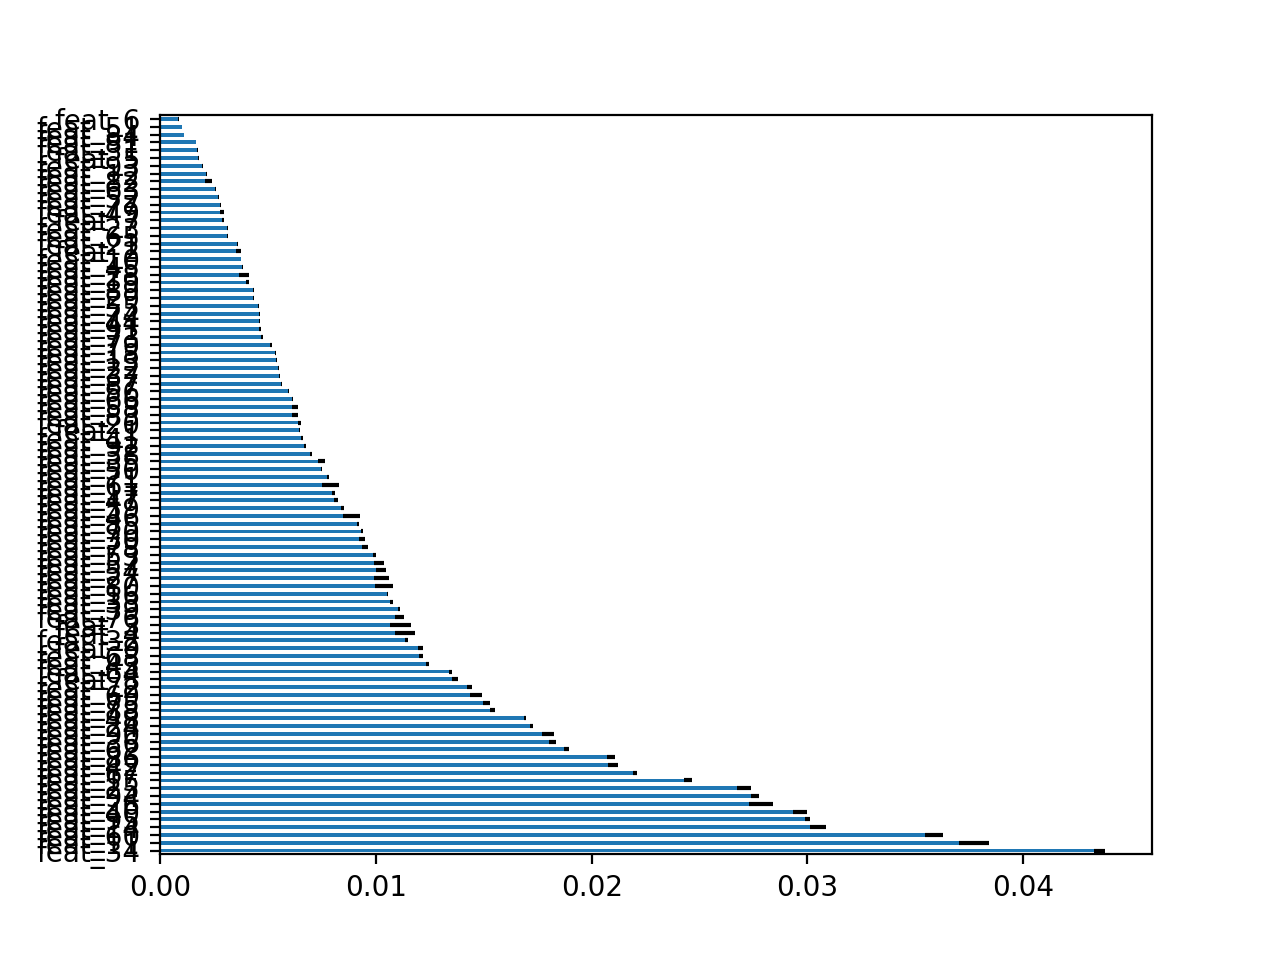

In [41]:
fig, ax = plt.subplots()
mdi = feat_importance_mdi(rf, X.columns)
mdi.plot(kind="barh", y="mean", legend=False, xerr="std", ax=ax)

In [43]:
# Worst 10 features:
mdi.tail(10)

,mean,std
feat_63,0.002565,0.000013
feat_82,0.002266,0.000164
feat_12,0.002158,0.000011
feat_93,0.001967,0.000013
feat_5,0.001787,0.000012
feat_31,0.001750,0.000016
feat_81,0.001669,0.000011
feat_84,0.001102,0.000011
feat_51,0.001019,0.000012
feat_6,0.000853,0.000007


class_weights:  {1: 3.4560221185415587, 2: 0.4263665046473949, 3: 0.8576697113941422, 4: 2.62829358039293, 5: 2.5238185374471573, 6: 0.4890453834115806, 7: 2.4194036170084074, 8: 0.8031160904308717, 9: 1.3901921940708304}
Permuting 95 features: 1/10
Permuting 95 features: 2/10
Permuting 95 features: 3/10
Permuting 95 features: 4/10
Permuting 95 features: 5/10
Permuting 95 features: 6/10
Permuting 95 features: 7/10
Permuting 95 features: 8/10
Permuting 95 features: 9/10
Permuting 95 features: 10/10


<IPython.core.display.Javascript object>


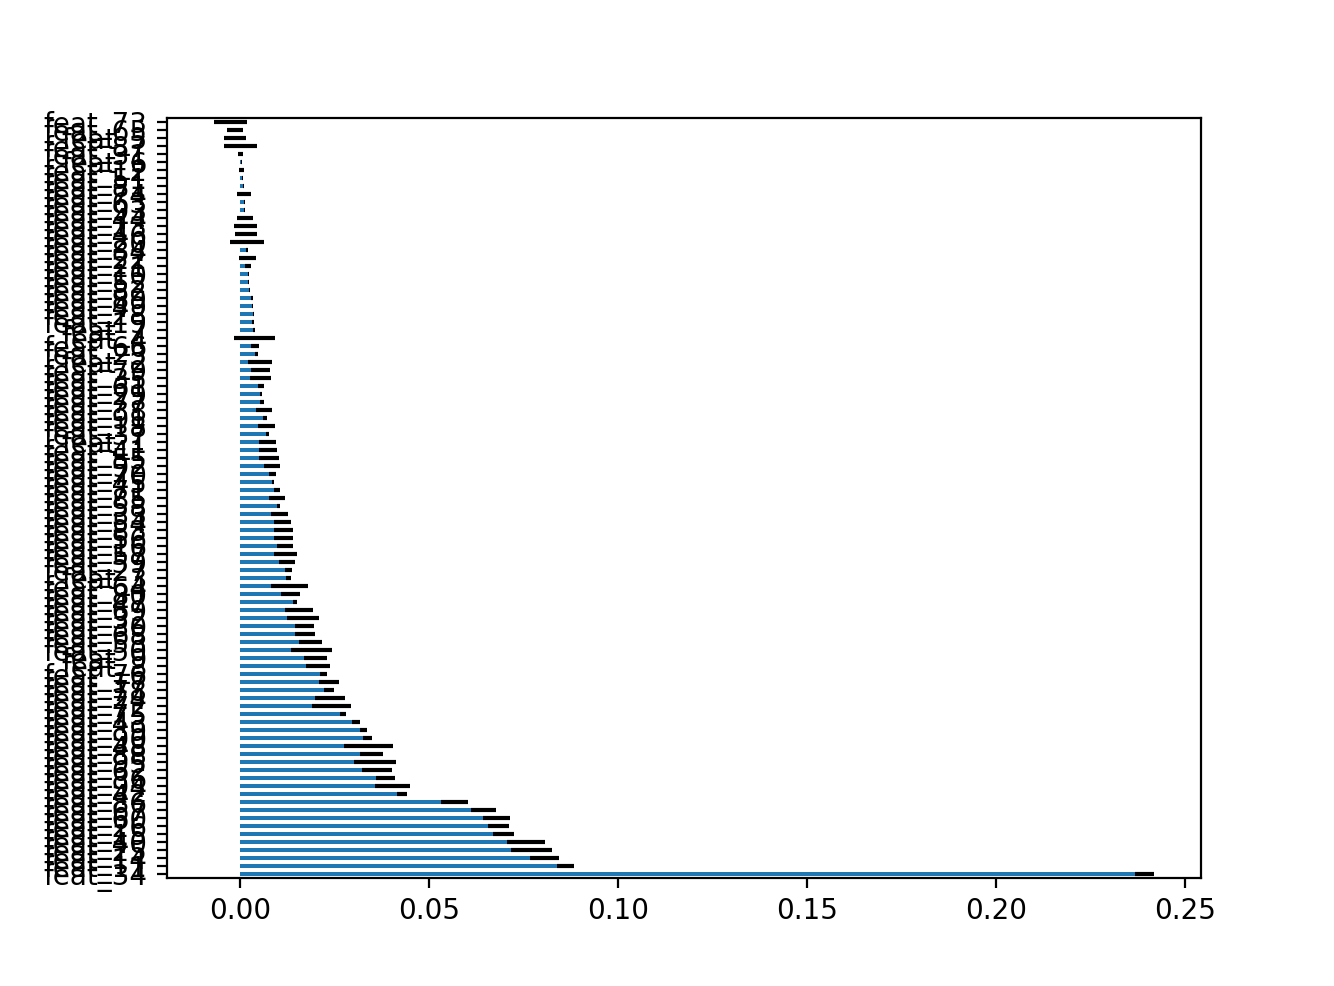

In [44]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
cv = StratifiedKFold(10, True)
mda, score = feat_importance_mda(rf, X_train.values, y_train.values, cv, 
                                 feat_names=X.columns, scoring="neg_log_loss")

fig, ax = plt.subplots()
mda.plot(kind="barh", y="mean", legend=False, xerr="std", ax=ax)

In [122]:
mda.tail(10)

,mean,std
feat_74,0.003015,0.000244
feat_89,0.002993,0.000242
feat_49,0.002992,0.000581
feat_84,0.002769,0.003655
feat_21,0.002727,0.000202
feat_10,0.002495,0.000450
feat_22,0.002396,0.001432
feat_52,0.002139,0.000308
feat_82,0.001936,0.000130
feat_73,0.001679,0.002111


In [45]:
to_remove = mda.loc[(mda["mean"] < 0.0015)].index.tolist()
to_remove

['feat_46',
 'feat_13',
 'feat_44',
 'feat_93',
 'feat_63',
 'feat_74',
 'feat_81',
 'feat_51',
 'feat_12',
 'feat_6',
 'feat_31',
 'feat_87',
 'feat_5',
 'feat_65',
 'feat_73']

class_weights:  {1: 3.4560221185415587, 2: 0.4263665046473949, 3: 0.8576697113941422, 4: 2.62829358039293, 5: 2.5238185374471573, 6: 0.4890453834115806, 7: 2.4194036170084074, 8: 0.8031160904308717, 9: 1.3901921940708304}
Permuting 95 features: 1/10
Permuting 95 features: 2/10
Permuting 95 features: 3/10
Permuting 95 features: 4/10
Permuting 95 features: 5/10
Permuting 95 features: 6/10
Permuting 95 features: 7/10
Permuting 95 features: 8/10
Permuting 95 features: 9/10
Permuting 95 features: 10/10


<IPython.core.display.Javascript object>


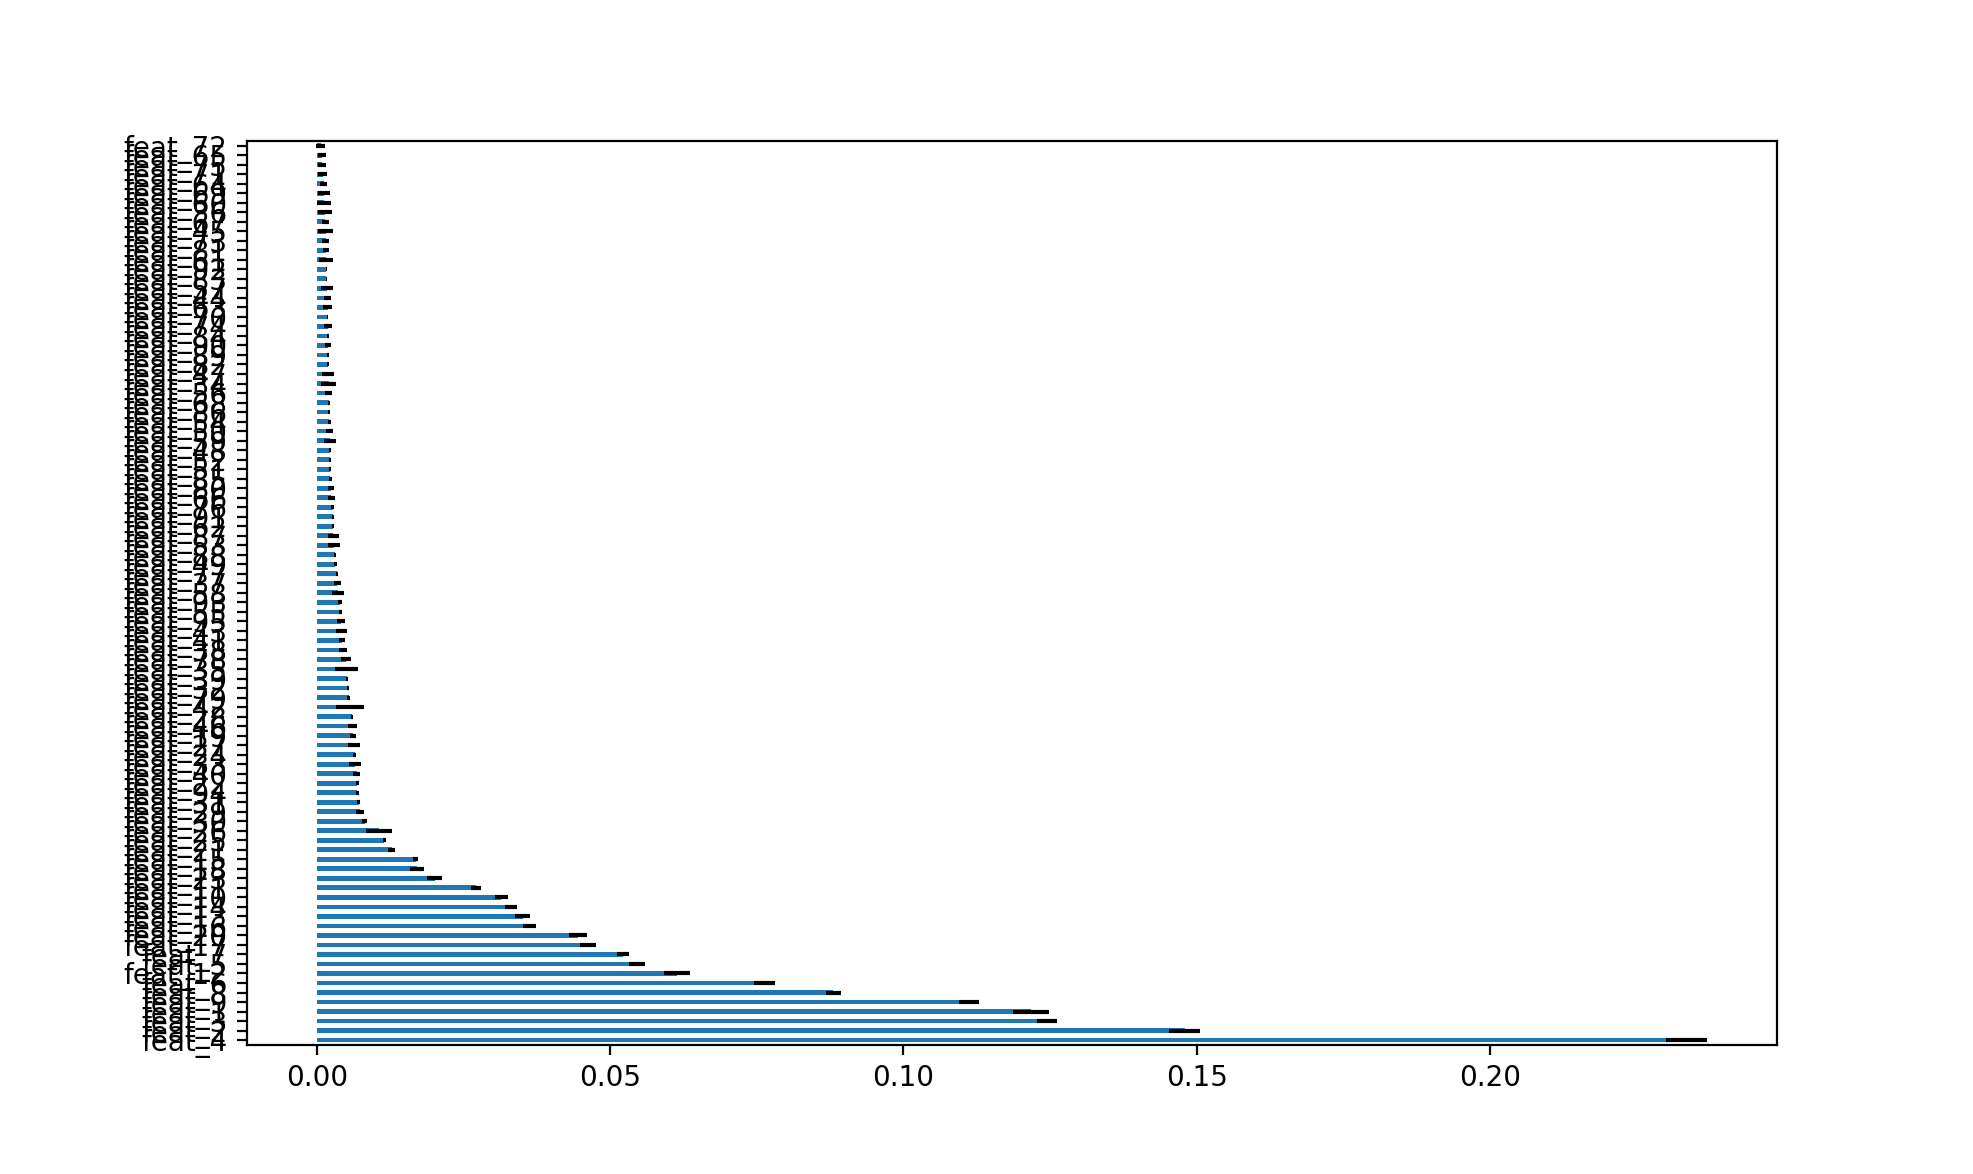

In [46]:
from sklearn.model_selection import StratifiedKFold

# same thing, but with PCA
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
cv = StratifiedKFold(10, True)
mda_pca, score = feat_importance_mda(rf, X_pca.values, y_pca.values, cv, 
                                 feat_names=X.columns, scoring="neg_log_loss")

fig, ax = plt.subplots()
mda_pca.plot(kind="barh", y="mean", legend=False, xerr="std", ax=ax)

In [54]:
var = pd.Series(pca.explained_variance_ratio_, index=log_data.columns)
var = var.loc[mda_pca.index]
mda_pca["explained_variance_ratio"] = var
mda_pca.tail(20)

,mean,std,explained_variance_ratio
feat_74,0.001869,0.000718,0.004287
feat_70,0.001815,0.000145,0.004541
feat_63,0.001810,0.000777,0.004986
feat_44,0.001807,0.000646,0.006855
feat_57,0.001722,0.001013,0.005616
feat_83,0.001633,0.000148,0.003531
feat_92,0.001618,0.000125,0.002556
feat_61,0.001569,0.001176,0.005283
feat_81,0.001560,0.000584,0.003695
feat_73,0.001494,0.000620,0.004323


In [55]:
to_drop_pca = (mda_pca["mean"] - mda_pca["std"]) <= 0
mda_pca.loc[to_drop_pca]

,mean,std,explained_variance_ratio
feat_72,0.000658,0.000761,0.004393


## Test if PCA should be before or after feature selection

In [6]:
to_drop_before_pca = ['feat_46','feat_13', 'feat_44', 'feat_93', 'feat_63', 'feat_74',
                      'feat_81', 'feat_51', 'feat_12', 'feat_6', 'feat_31', 'feat_87',
                      'feat_5', 'feat_65', 'feat_73']
to_drop_after_pca = [71, 65, 74, 70]

In [57]:
subsample_size = 40000
pca = PCA(n_components=d)
log_data = np.log(df_train.drop(columns=["target"]) + 1)
log_train = log_data.iloc[:subsample_size]
log_test = log_data.iloc[subsample_size:]
scaler = StandardScaler()
scaled_train = scaler.fit_transform(log_train)
scaled_test = scaler.transform(log_test)
X_pca_tr = pca.fit_transform(scaled_train)
X_pca_te = pca.transform(scaled_test)
X_pca_tr = np.delete(X_pca_tr, to_drop_after_pca, axis=1)
X_pca_te = np.delete(X_pca_te, to_drop_after_pca, axis=1)

y_train = df_train["target"].iloc[:subsample_size]
y_test = df_train["target"].iloc[subsample_size:]

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf.fit(X_pca_tr, y_train)
y_pca_select = rf.predict(X_pca_te)

cm1 = confusion_matrix_df(y_true=y_test, y_pred=y_pca_select)
cm1

,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,recall
true_1,187.000000,33.000000,3.000000,0.000000,5.000000,97.000000,21.000000,154.000000,143.000000,0.290824
true_2,1.000000,5130.000000,450.000000,0.000000,17.000000,30.000000,38.000000,20.000000,12.000000,0.900316
true_3,0.000000,1642.000000,1104.000000,8.000000,1.000000,6.000000,42.000000,14.000000,5.000000,0.391212
true_4,0.000000,632.000000,177.000000,126.000000,8.000000,47.000000,7.000000,1.000000,2.000000,0.126000
true_5,3.000000,26.000000,1.000000,0.000000,940.000000,3.000000,0.000000,3.000000,2.000000,0.961145
true_6,9.000000,59.000000,6.000000,1.000000,1.000000,4759.000000,52.000000,102.000000,58.000000,0.942936
true_7,4.000000,142.000000,69.000000,2.000000,4.000000,93.000000,607.000000,77.000000,4.000000,0.605788
true_8,11.000000,36.000000,2.000000,0.000000,2.000000,139.000000,14.000000,2698.000000,28.000000,0.920819
true_9,13.000000,49.000000,3.000000,0.000000,2.000000,72.000000,6.000000,81.000000,1532.000000,0.871445
precision,0.820175,0.662021,0.608264,0.919708,0.959184,0.907167,0.771283,0.856508,0.857783,0.780830


In [60]:
df_selected = df_train.drop(columns=to_drop_before_pca)
pca = PCA(n_components=df_selected.shape[1]-1)
log_data = np.log(df_selected.drop(columns=["target"]) + 1)
log_train = log_data.iloc[:subsample_size]
log_test = log_data.iloc[subsample_size:]
scaler = StandardScaler()
scaled_train = scaler.fit_transform(log_train)
scaled_test = scaler.transform(log_test)
X_pca_tr = pca.fit_transform(scaled_train)
X_pca_te = pca.transform(scaled_test)

y_train = df_train["target"].iloc[:subsample_size]
y_test = df_train["target"].iloc[subsample_size:]

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf.fit(X_pca_tr, y_train)
y_select_pca = rf.predict(X_pca_te)

cm2 = confusion_matrix_df(y_true=y_test, y_pred=y_select_pca)
cm2

,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,recall
true_1,176.000000,35.000000,2.000000,0.000000,4.000000,77.000000,18.000000,174.000000,157.000000,0.273717
true_2,0.000000,5128.000000,449.000000,2.000000,15.000000,26.000000,38.000000,25.000000,15.000000,0.899965
true_3,0.000000,1621.000000,1118.000000,9.000000,1.000000,8.000000,49.000000,11.000000,5.000000,0.396173
true_4,0.000000,629.000000,185.000000,128.000000,8.000000,42.000000,6.000000,0.000000,2.000000,0.128000
true_5,1.000000,22.000000,0.000000,0.000000,945.000000,5.000000,0.000000,1.000000,4.000000,0.966258
true_6,8.000000,66.000000,7.000000,2.000000,1.000000,4725.000000,63.000000,122.000000,53.000000,0.936200
true_7,4.000000,144.000000,64.000000,2.000000,4.000000,90.000000,605.000000,83.000000,6.000000,0.603792
true_8,9.000000,41.000000,2.000000,0.000000,3.000000,116.000000,13.000000,2718.000000,28.000000,0.927645
true_9,14.000000,52.000000,2.000000,0.000000,2.000000,70.000000,6.000000,77.000000,1535.000000,0.873151
precision,0.830189,0.662704,0.611263,0.895105,0.961343,0.915875,0.758145,0.846465,0.850416,0.780602


Since the performance is similar with simple RF, I will drop the features before PCA because 
they might bring more noise than signal and that will be propagated with PCA.

## Other

# 2D Visualizations

In [7]:
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [8]:
def plot_by_label(X, y):
    #fig, ax = plt.subplots()
    df = pd.DataFrame(dict(x=X[:, 0], y=X[:, 1], label=y))
    sns.pairplot(x_vars=["x"], y_vars=["y"], data=df, hue="label", height=5, aspect=1.0)
    #groups = df.groupby('label')
    
    #
    #ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    #for name, group in groups:
    #    ax.plot(group.x, group.y, marker='o', linestyle='', ms=2, label=name)
    #ax.legend()
    plt.show()

In [18]:
df_train = df_train.sample(frac=1)   # shuffle
X = df_train.drop(columns=["target"])
X_scaled = X.copy()
y = np.array(df_train["target"].values)

raw_feat_cols = [c for c in X.columns if c.startswith("feat_")]
X_scaled[raw_feat_cols] = np.log(X_scaled[raw_feat_cols] + 1.0)
X = np.array(X.values)
X_scaled = np.array(X_scaled.values)

X_scaled = StandardScaler().fit_transform(X_scaled)

train_size = -1
if train_size > 0:
    X = X[:train_size]
    X_scaled = X_scaled[:train_size]
    y = y[:train_size]
print(X.shape)

(61878, 95)


/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/numba/typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/umap/nndescent.py:91: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../..

<IPython.core.display.Javascript object>


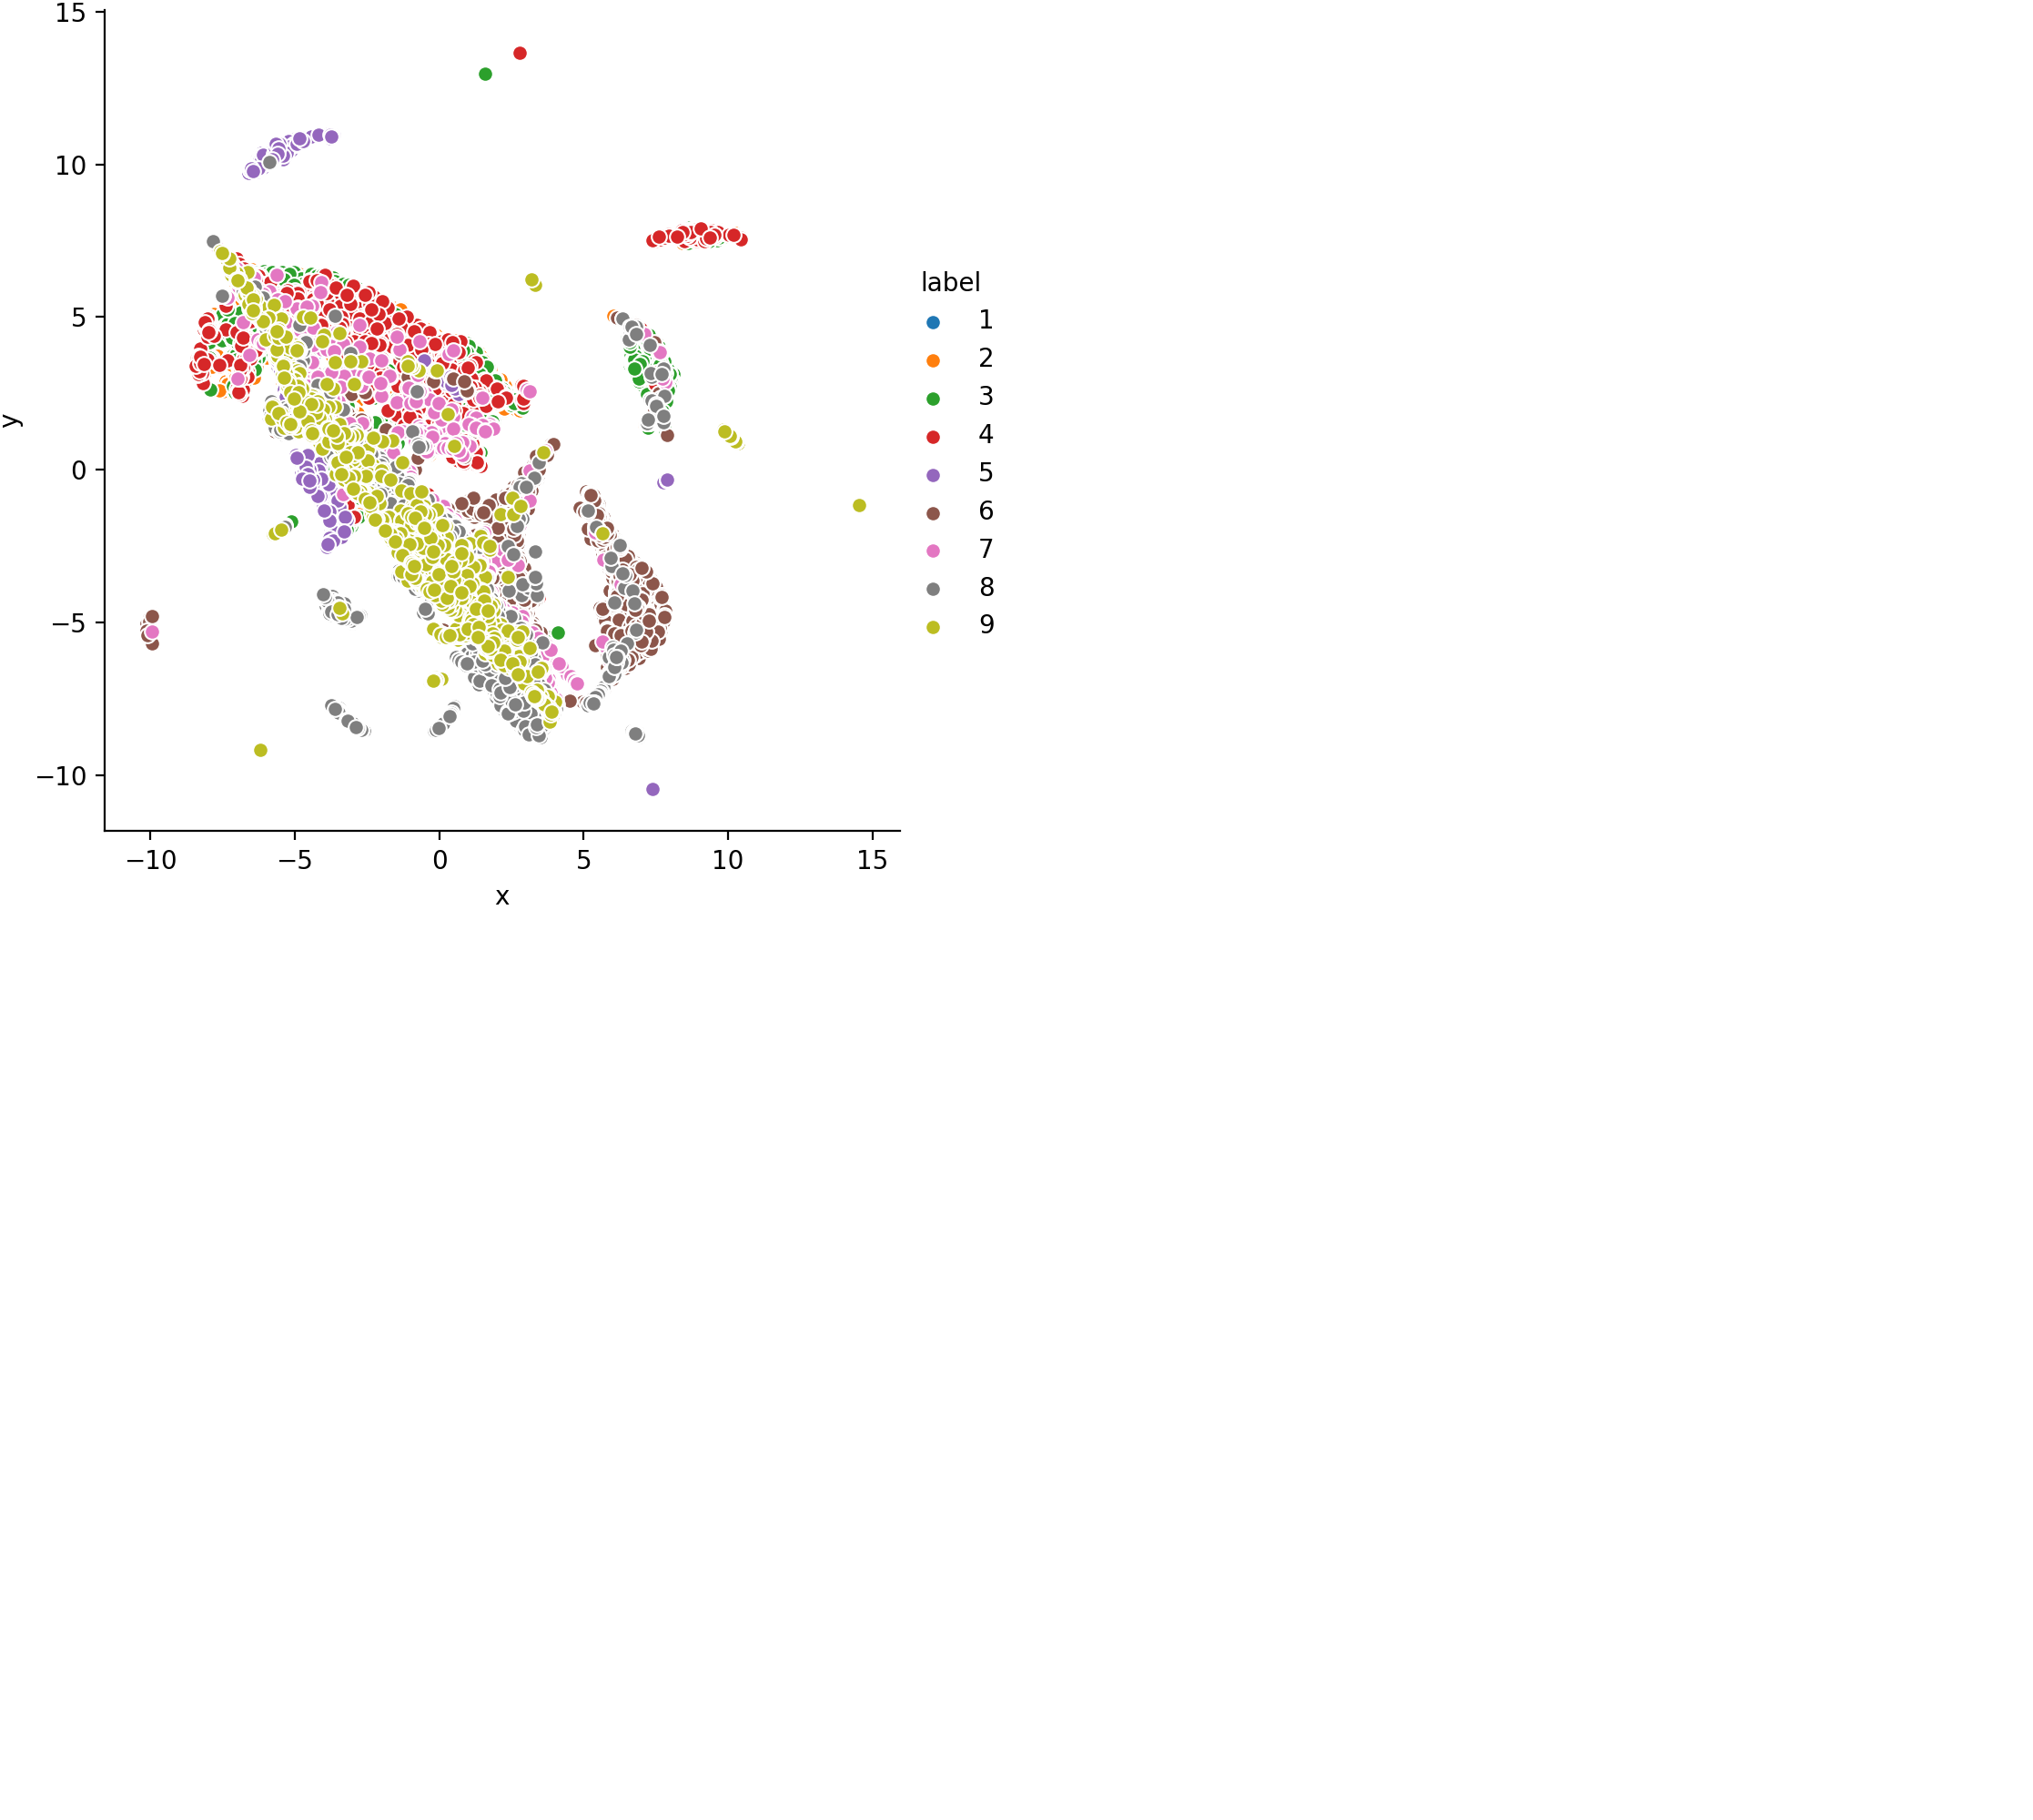

In [10]:
mapper = umap.UMAP(n_neighbors=20).fit(X)
X_umap = mapper.transform(X)

plot_by_label(X_umap, y)

/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/numba/typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


<IPython.core.display.Javascript object>


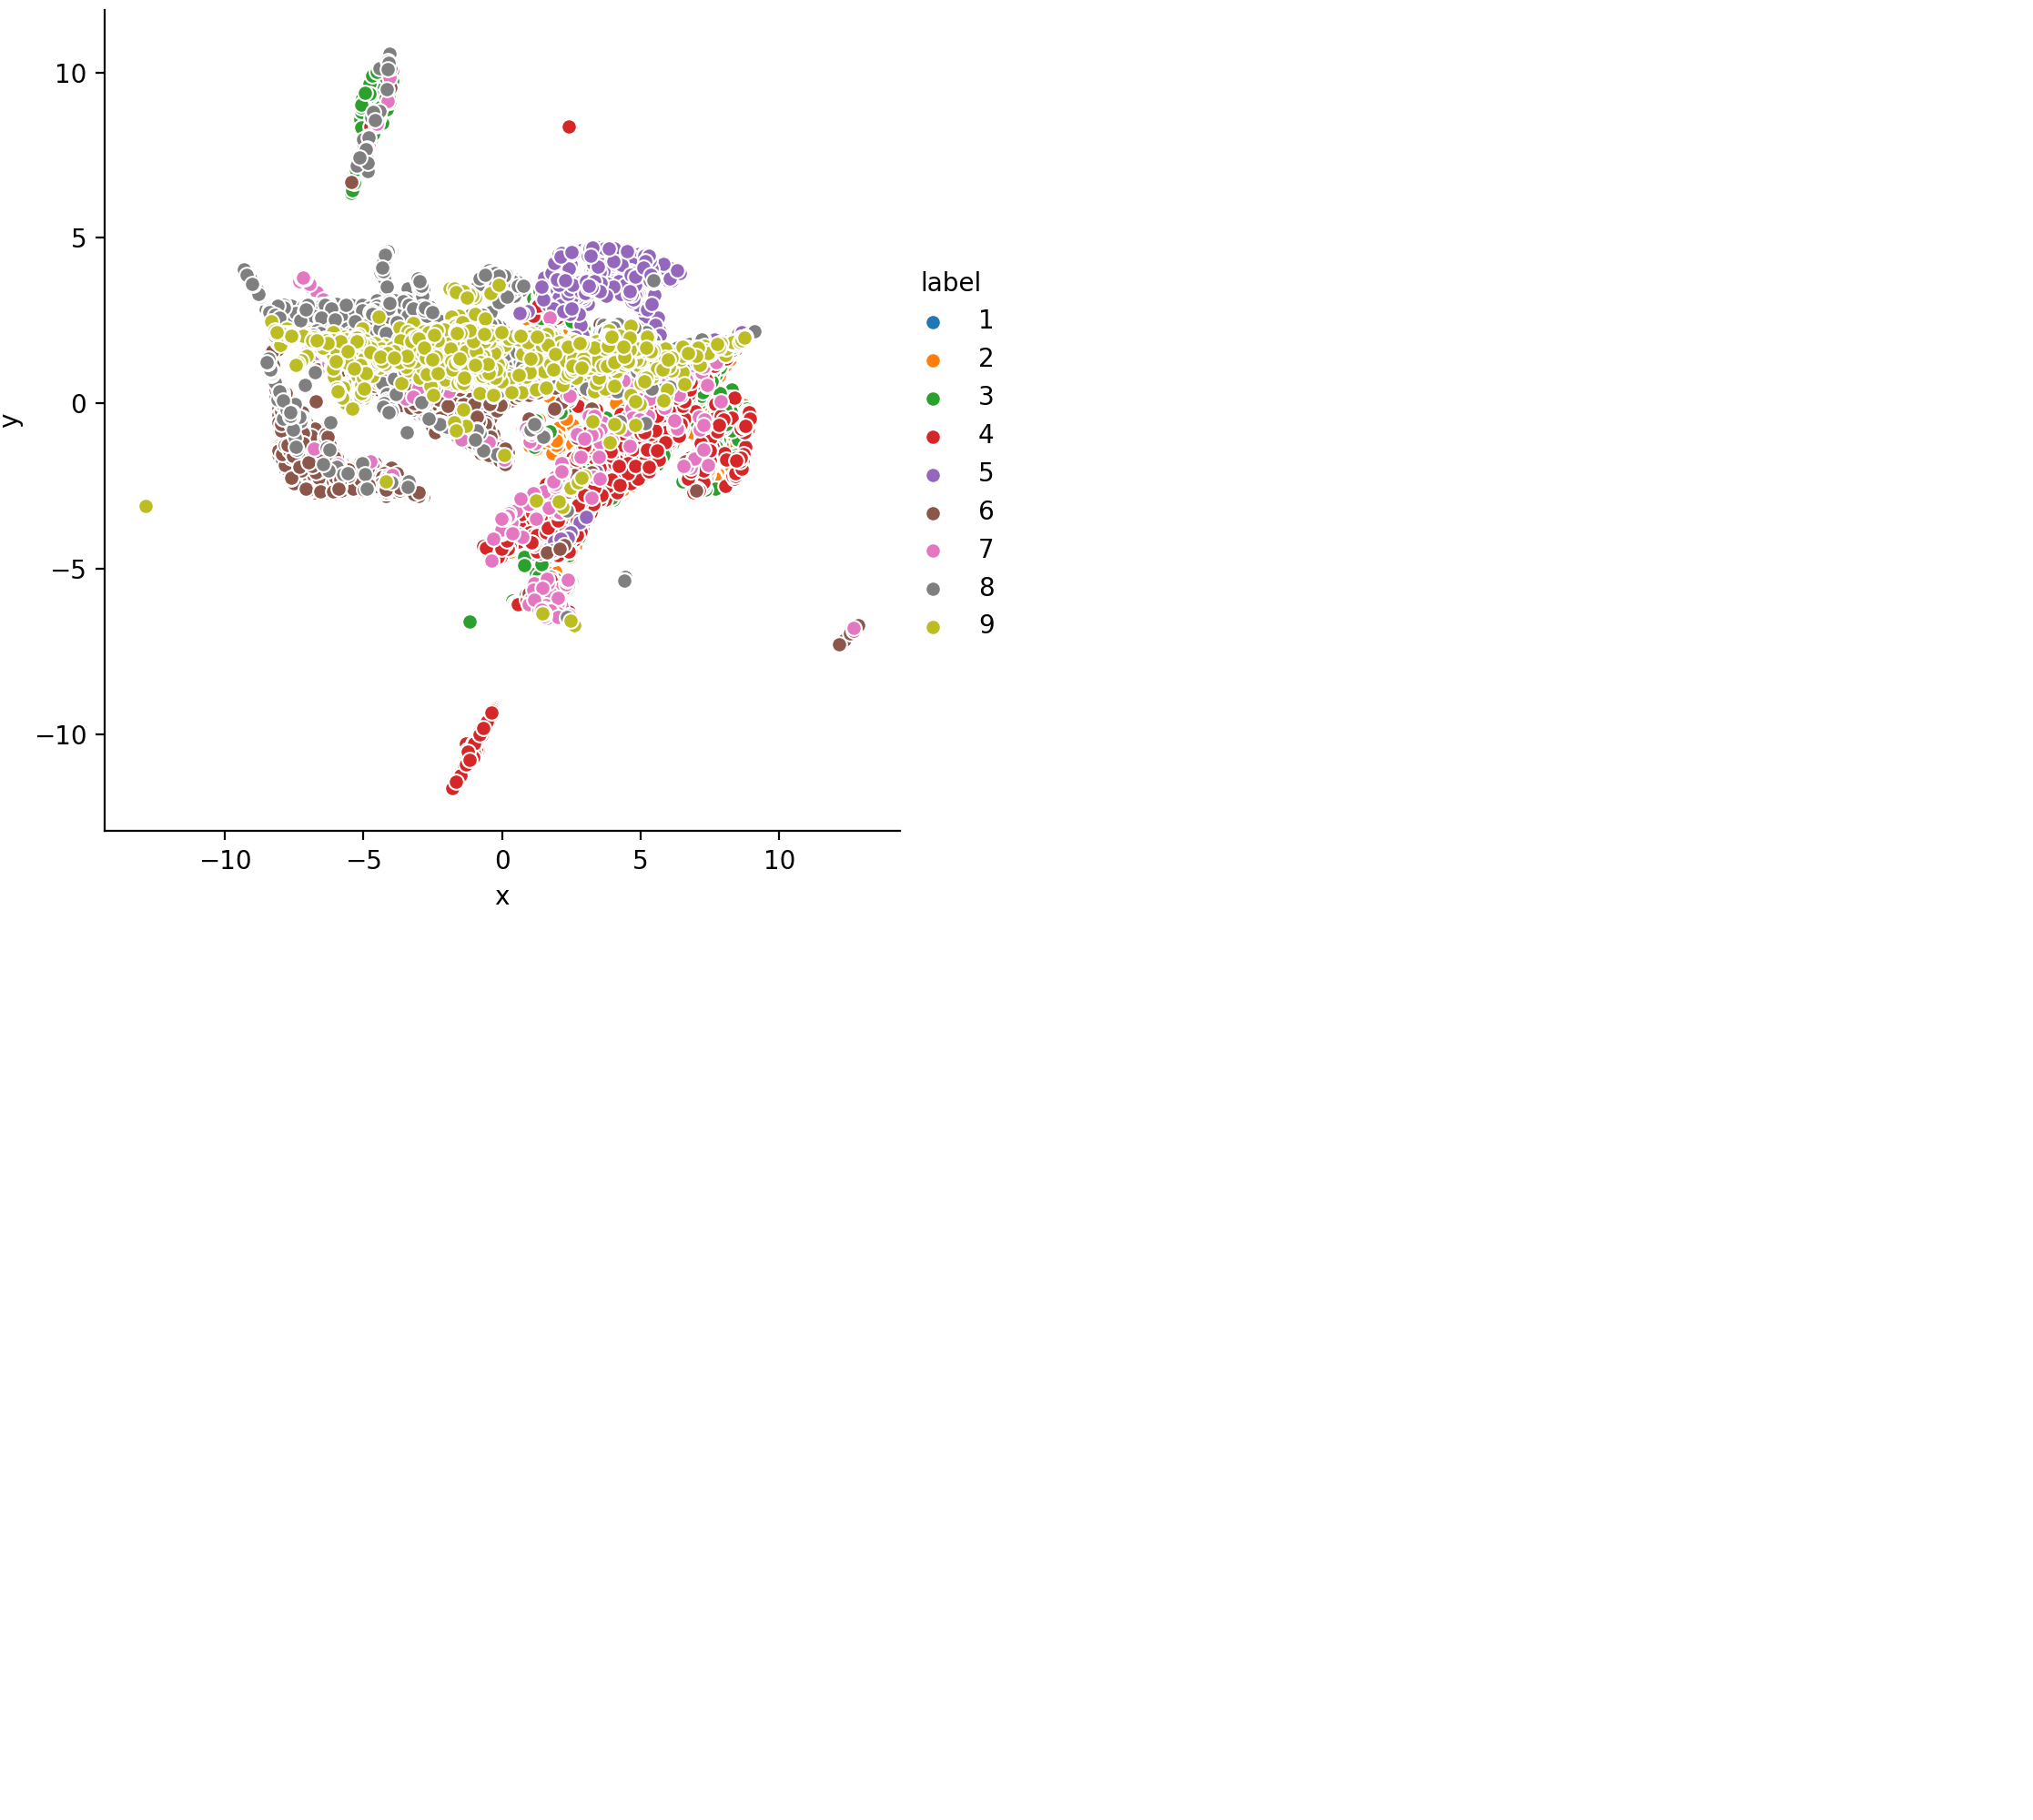

In [11]:
mapper = umap.UMAP(n_neighbors=40).fit(X)
X_umap = mapper.transform(X)

plot_by_label(X_umap, y)

/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/numba/typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


<IPython.core.display.Javascript object>


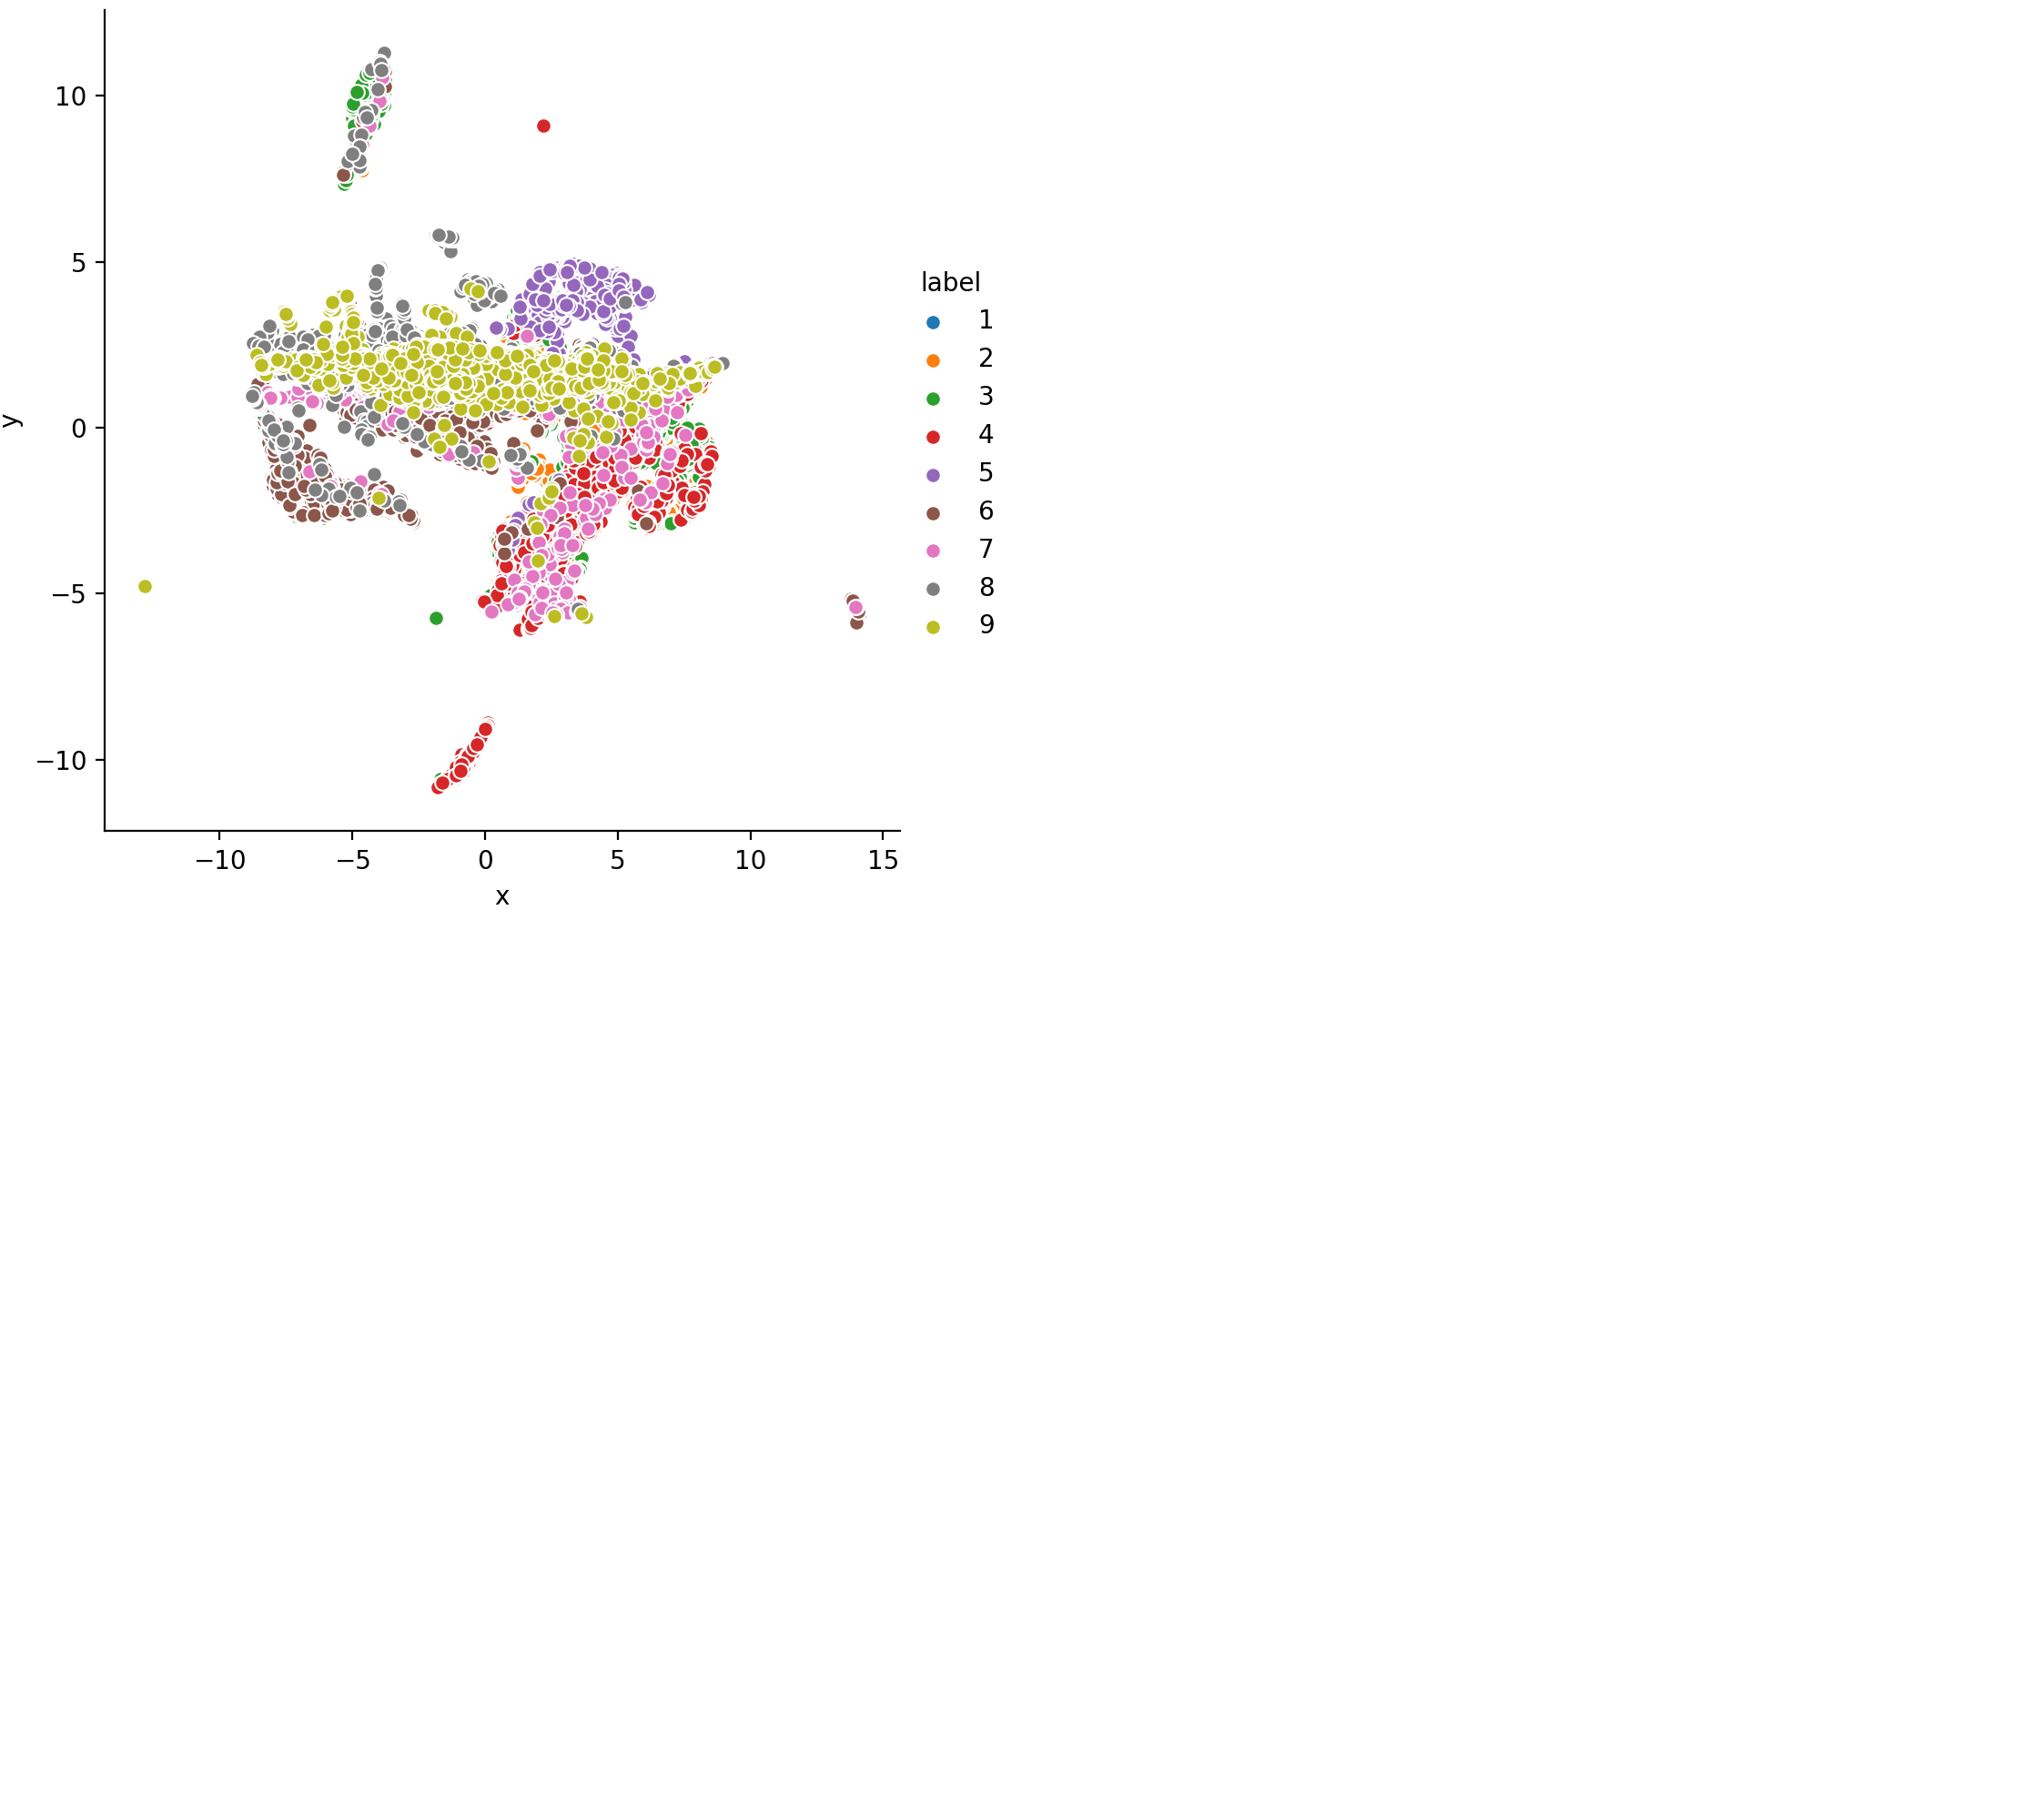

In [17]:
mapper = umap.UMAP(n_neighbors=40).fit(X)
X_umap = mapper.embedding_

plot_by_label(X_umap, y)

# Train Benchmark Model

In [7]:
df_clean = df_train.drop(columns=to_drop_before_pca)
X = df_clean.drop(columns="target")
y = df_clean["target"] - 1

X = np.log(X + 1)
d = X.shape[1]
train_size = int(0.7 * X.shape[0])
valdiation_id = int(0.8 * X.shape[0])

print(f"train_size: {train_size}, d: {d}")

X_train, y_train = X.iloc[:train_size], y.iloc[:train_size]
X_val, y_val = X.iloc[train_size:valdiation_id], y.iloc[train_size:valdiation_id]
X_test, y_test = X.iloc[valdiation_id:], y.iloc[valdiation_id:]

pipe = Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=d))])
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)
X_val = pipe.transform(X_val)

cv = StratifiedKFold(5, shuffle=True, random_state=442)

train_size: 43314, d: 80


## Hyper-param tuning for different models that will be used in the main code
### LightGBM

In [44]:
param_grid = {
    "learning_rate" : [0.05,0.1],
    "num_leaves": [600, 900, 1200],
    "n_estimators": [1000],
    "max_depth": [25, 50, 75],
    "min_data_in_leaf": [30],
    "subsample": [0.4, 0.6],
    "bagging_freq": [1],
    "feature_fraction": [0.4, 0.6],
    "early_stopping_rounds": [10],
}

lg = lgb.LGBMClassifier(silent=False, objective="softmax", num_class=n_classes, n_jobs=1)

eval_set = [(X_val, y_val)]

grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_grid, cv=cv, scoring="neg_log_loss", verbose=5)
grid_search.fit(X_train, y_train, eval_set=eval_set)
grid_search.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 61.0min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed: 128.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 160.0min finished
/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.85431
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.77697
[3]	valid_0's multi_logloss: 1.70868
[4]	valid_0's multi_logloss: 1.65042
[5]	valid_0's multi_logloss: 1.59561
[6]	valid_0's multi_logloss: 1.54359
[7]	valid_0's multi_logloss: 1.4959
[8]	valid_0's multi_logloss: 1.45534
[9]	valid_0's multi_logloss: 1.41432
[10]	valid_0's multi_logloss: 1.37577
[11]	valid_0's multi_logloss: 1.34077
[12]	valid_0's multi_logloss: 1.30923
[13]	valid_0's multi_logloss: 1.27809
[14]	valid_0's multi_logloss: 1.24805
[15]	valid_0's multi_logloss: 1.22327
[16]	valid_0's multi_logloss: 1.19693
[17]	valid_0's multi_logloss: 1.17165
[18]	valid_0's multi_logloss: 1.14923
[19]	valid_0's multi_logloss: 1.12714
[20]	valid_0's multi_logloss: 1.10692
[21]	valid_0's multi_logloss: 1.08681
[22]	valid_0's multi_logloss: 1.06781
[23]	valid_0's multi_logloss: 1.04906
[24]	valid_0's multi_logloss: 1.03109
[25]	valid_0's multi_logloss: 1.013
[

LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, early_stopping_rounds=10,
               feature_fraction=0.6, importance_type='split',
               learning_rate=0.05, max_depth=25, min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=30, min_split_gain=0.0,
               n_estimators=1000, n_jobs=1, num_class=9, num_leaves=600,
               objective='softmax', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=False, subsample=0.4,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
clf = grid_search.best_estimator_
y_pred = clf.predict(X_test)
#y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix_df(y_true=y_test, y_pred=y_pred)
cm

In [48]:
param_grid = {
    "learning_rate" : 0.01,
    "num_leaves": 500,
    "n_estimators": 1500,
    "max_depth": 25,
    "min_data_in_leaf": 30,
    "subsample": 0.4,
    "bagging_freq": 1,
    "feature_fraction": 0.6,
    "early_stopping_rounds": 10,
}

# train_data = lgb.Dataset(X_train, label=y_train, feature_name=list(X.columns))
# val_data = lgb.Dataset(X_val, label=y_val, feature_name=list(X.columns))

lg2 = lgb.LGBMClassifier(silent=False, objective="softmax", num_class=n_classes, verbose=1, **param_grid)

eval_set = [(X_val, y_val)]
lg2.fit(X_train, y_train, eval_set=eval_set)

/opt/anaconda3/envs/mlenv/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.93138
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 1.913
[3]	valid_0's multi_logloss: 1.89506
[4]	valid_0's multi_logloss: 1.87863
[5]	valid_0's multi_logloss: 1.86254
[6]	valid_0's multi_logloss: 1.84595
[7]	valid_0's multi_logloss: 1.82956
[8]	valid_0's multi_logloss: 1.81539
[9]	valid_0's multi_logloss: 1.8004
[10]	valid_0's multi_logloss: 1.78524
[11]	valid_0's multi_logloss: 1.77114
[12]	valid_0's multi_logloss: 1.75803
[13]	valid_0's multi_logloss: 1.74486
[14]	valid_0's multi_logloss: 1.73167
[15]	valid_0's multi_logloss: 1.72005
[16]	valid_0's multi_logloss: 1.70768
[17]	valid_0's multi_logloss: 1.69512
[18]	valid_0's multi_logloss: 1.68384
[19]	valid_0's multi_logloss: 1.67233
[20]	valid_0's multi_logloss: 1.66121
[21]	valid_0's multi_logloss: 1.65014
[22]	valid_0's multi_logloss: 1.63899
[23]	valid_0's multi_logloss: 1.62811
[24]	valid_0's multi_logloss: 1.6173
[25]	valid_0's multi_logloss: 1.60642
[2

[211]	valid_0's multi_logloss: 0.80614
[212]	valid_0's multi_logloss: 0.804463
[213]	valid_0's multi_logloss: 0.802785
[214]	valid_0's multi_logloss: 0.801057
[215]	valid_0's multi_logloss: 0.799484
[216]	valid_0's multi_logloss: 0.797847
[217]	valid_0's multi_logloss: 0.796248
[218]	valid_0's multi_logloss: 0.794552
[219]	valid_0's multi_logloss: 0.792921
[220]	valid_0's multi_logloss: 0.791326
[221]	valid_0's multi_logloss: 0.789716
[222]	valid_0's multi_logloss: 0.78822
[223]	valid_0's multi_logloss: 0.786737
[224]	valid_0's multi_logloss: 0.785177
[225]	valid_0's multi_logloss: 0.783588
[226]	valid_0's multi_logloss: 0.782041
[227]	valid_0's multi_logloss: 0.780555
[228]	valid_0's multi_logloss: 0.779015
[229]	valid_0's multi_logloss: 0.777445
[230]	valid_0's multi_logloss: 0.77592
[231]	valid_0's multi_logloss: 0.774621
[232]	valid_0's multi_logloss: 0.773119
[233]	valid_0's multi_logloss: 0.771646
[234]	valid_0's multi_logloss: 0.770176
[235]	valid_0's multi_logloss: 0.768771
[23

[417]	valid_0's multi_logloss: 0.617042
[418]	valid_0's multi_logloss: 0.616564
[419]	valid_0's multi_logloss: 0.616069
[420]	valid_0's multi_logloss: 0.615612
[421]	valid_0's multi_logloss: 0.615108
[422]	valid_0's multi_logloss: 0.6146
[423]	valid_0's multi_logloss: 0.614087
[424]	valid_0's multi_logloss: 0.613574
[425]	valid_0's multi_logloss: 0.613119
[426]	valid_0's multi_logloss: 0.612642
[427]	valid_0's multi_logloss: 0.612206
[428]	valid_0's multi_logloss: 0.611731
[429]	valid_0's multi_logloss: 0.611308
[430]	valid_0's multi_logloss: 0.610955
[431]	valid_0's multi_logloss: 0.610494
[432]	valid_0's multi_logloss: 0.609974
[433]	valid_0's multi_logloss: 0.609531
[434]	valid_0's multi_logloss: 0.609148
[435]	valid_0's multi_logloss: 0.608773
[436]	valid_0's multi_logloss: 0.608368
[437]	valid_0's multi_logloss: 0.608005
[438]	valid_0's multi_logloss: 0.607597
[439]	valid_0's multi_logloss: 0.607186
[440]	valid_0's multi_logloss: 0.606771
[441]	valid_0's multi_logloss: 0.606394
[4

[623]	valid_0's multi_logloss: 0.560304
[624]	valid_0's multi_logloss: 0.560214
[625]	valid_0's multi_logloss: 0.560067
[626]	valid_0's multi_logloss: 0.559919
[627]	valid_0's multi_logloss: 0.559755
[628]	valid_0's multi_logloss: 0.559614
[629]	valid_0's multi_logloss: 0.559462
[630]	valid_0's multi_logloss: 0.559375
[631]	valid_0's multi_logloss: 0.559282
[632]	valid_0's multi_logloss: 0.559099
[633]	valid_0's multi_logloss: 0.55897
[634]	valid_0's multi_logloss: 0.55878
[635]	valid_0's multi_logloss: 0.558657
[636]	valid_0's multi_logloss: 0.558545
[637]	valid_0's multi_logloss: 0.55836
[638]	valid_0's multi_logloss: 0.558211
[639]	valid_0's multi_logloss: 0.558095
[640]	valid_0's multi_logloss: 0.557997
[641]	valid_0's multi_logloss: 0.557838
[642]	valid_0's multi_logloss: 0.557673
[643]	valid_0's multi_logloss: 0.557533
[644]	valid_0's multi_logloss: 0.557383
[645]	valid_0's multi_logloss: 0.557252
[646]	valid_0's multi_logloss: 0.557072
[647]	valid_0's multi_logloss: 0.556952
[64

[829]	valid_0's multi_logloss: 0.543702
[830]	valid_0's multi_logloss: 0.543665
[831]	valid_0's multi_logloss: 0.543613
[832]	valid_0's multi_logloss: 0.543608
[833]	valid_0's multi_logloss: 0.543586
[834]	valid_0's multi_logloss: 0.543557
[835]	valid_0's multi_logloss: 0.543568
[836]	valid_0's multi_logloss: 0.543536
[837]	valid_0's multi_logloss: 0.54353
[838]	valid_0's multi_logloss: 0.543524
[839]	valid_0's multi_logloss: 0.543475
[840]	valid_0's multi_logloss: 0.543459
[841]	valid_0's multi_logloss: 0.543488
[842]	valid_0's multi_logloss: 0.543412
[843]	valid_0's multi_logloss: 0.543377
[844]	valid_0's multi_logloss: 0.543331
[845]	valid_0's multi_logloss: 0.543281
[846]	valid_0's multi_logloss: 0.543262
[847]	valid_0's multi_logloss: 0.543202
[848]	valid_0's multi_logloss: 0.543172
[849]	valid_0's multi_logloss: 0.543091
[850]	valid_0's multi_logloss: 0.543125
[851]	valid_0's multi_logloss: 0.543092
[852]	valid_0's multi_logloss: 0.543113
[853]	valid_0's multi_logloss: 0.543082
[

LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, early_stopping_rounds=10,
               feature_fraction=0.6, importance_type='split',
               learning_rate=0.01, max_depth=25, min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=30, min_split_gain=0.0,
               n_estimators=1500, n_jobs=-1, num_class=9, num_leaves=500,
               objective='softmax', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=False, subsample=0.4,
               subsample_for_bin=200000, subsample_freq=0, verbose=1)

In [49]:
y_pred = lg2.predict(X_test)
#y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix_df(y_true=y_test, y_pred=y_pred)
cm

,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,recall
true_1,148.000000,15.000000,1.000000,0.000000,3.000000,36.000000,9.000000,79.000000,91.000000,0.387435
true_2,1.000000,2789.000000,383.000000,17.000000,2.000000,7.000000,16.000000,6.000000,8.000000,0.863735
true_3,0.000000,777.000000,781.000000,11.000000,0.000000,2.000000,23.000000,9.000000,0.000000,0.487211
true_4,0.000000,253.000000,106.000000,173.000000,5.000000,22.000000,7.000000,1.000000,1.000000,0.304577
true_5,1.000000,16.000000,0.000000,0.000000,536.000000,3.000000,1.000000,0.000000,1.000000,0.960573
true_6,5.000000,30.000000,7.000000,0.000000,0.000000,2674.000000,33.000000,49.000000,42.000000,0.941549
true_7,8.000000,68.000000,44.000000,2.000000,2.000000,48.000000,353.000000,41.000000,3.000000,0.620387
true_8,12.000000,18.000000,5.000000,0.000000,0.000000,56.000000,6.000000,1519.000000,17.000000,0.930190
true_9,20.000000,30.000000,0.000000,1.000000,0.000000,37.000000,4.000000,43.000000,859.000000,0.864185
precision,0.758974,0.697948,0.588546,0.848039,0.978102,0.926863,0.780973,0.869491,0.840509,0.794441


### Random Forest

In [9]:
param_grid = {
    "max_depth": [16],#, 32],#, 64],
    "min_samples_leaf": [10, 30, 50],
    "max_features": [0.4, 0.6],
}

rf = RandomForestClassifier(n_estimators=700, n_jobs=2)

eval_set = [(X_val, y_val)]

grid_search = GridSearchCV(rf, n_jobs=-1, param_grid=param_grid, cv=cv, scoring="neg_log_loss", verbose=2)
grid_search.fit(X_train, y_train)
print(f"Score: {grid_search.best_score_}")
grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed: 53.3min remaining: 16.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 64.0min finished


Score: -0.6666970256384015


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=16, max_features=0.6,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [23]:
clf0 = XGBClassifier(n_estimators=200, n_jobs=-1, objective="multi:softprob", verbose=True)

clf0.fit(X_mapped, y)

y_pred = clf0.predict_proba(X_mapped)
loss = log_loss(y_pred=y_pred, y_true=y)
print(loss)

0.2150888313001392


In [23]:
clf = XGBClassifier(n_jobs=-1, objective="multi:softprob", verbosity=2)

space = [
    Integer(100, 500, name='n_estimators'),
    Integer(1, 8, name='max_depth'),
    Real(1e-3, 1, "log-uniform", name='learning_rate'),
    Real(1e-3, 1, "log-uniform", name='reg_alpha'),
    Real(1e-3, 1, "log-uniform", name='reg_lambda'),
    Real(0.3, 0.6, "uniform", name='subsample'),
    Real(0.6, 1.0, "uniform", name="colsample_bytree")
]

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)
    return -np.mean(cross_val_score(clf, X_mapped, y_encoded, cv=5, scoring="neg_log_loss", n_jobs=-1))


res_gp = gp_minimize(objective, space, n_calls=20, n_random_starts=5, verbose=True, n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 71.1824
Function value obtained: 0.7407
Current minimum: 0.7407
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 213.6200
Function value obtained: 1.1201
Current minimum: 0.7407
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 107.1933
Function value obtained: 1.6125
Current minimum: 0.7407
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 49.2046
Function value obtained: 0.6903
Current minimum: 0.6903
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 77.6606
Function value obtained: 1.2978
Current minimum: 0.6903
Iteration No: 6 started. Sea

In [ ]:
mapper.embedding_

In [48]:
import sklearn
sklearn.__version__

'0.22.1'

In [24]:
print(f"Best score={res_gp.fun}")

#############################################################################

print(f"""Best parameters:
- n_estimators={res_gp.x[0]}
- max_depth={res_gp.x[1]}
- learning_rate={res_gp.x[2]}
- reg_alpha={res_gp.x[3]}
- reg_lambda={res_gp.x[4]}
- subsample={res_gp.x[5]}
- colsample_bytree={res_gp.x[6]}
""")

#############################################################################
# Convergence plot
# ================

from skopt.plots import plot_convergence

plot_convergence(res_gp)

Best score=0.6725291527523407
Best parameters:
- n_estimators=500
- max_depth=8
- learning_rate=0.03893087362583735
- reg_alpha=0.001
- reg_lambda=1.0
- subsample=0.6
- colsample_bytree=1.0

